# Mini Project 1: Deep Q-learning for Epdicemic Mitigation

**Amin Asadi Sarijalou**: **347814**

**Ilker Gül**: **353296**

## Introduction

### Description

### Environment Setup

1. Install conda if you don't have it (see [the conda documentation here](https://conda.io/projects/conda/en/latest/user-guide/install/index.html) to learn how to do so)
2. Create a dedicated environment and install the packages in the environment by running the following commands:
```
conda create -n epi
conda activate epi
conda install pytorch torchvision torchaudio -c pytorch
conda install numpy networkx matplotlib pyyaml jupyter tqdm pandas
pip install gym
pip install ipykernel
```

In [1]:
# !pip install torch torchvision torchaudio
# !pip install numpy networkx matplotlib pyyaml jupyter tqdm pandas
# !pip install gym
# !pip install ipykernel

### Importing necessary libraries

#Checklist

- Question 1: **No epidemic mitigation**
  - plot of all variables over time
  - plot of only i,d over time
  - plot of plots i_city, d_city per city
  - Discuss the evolution of the variables over time.


- Question 2: **Professor Russo's Policy**
  - same 3 plots as above
  - action plot
  - Discuss how simulation responds to this policy (focus on difference from question 1)
  - Plot 3 histograms


- Question 3: ****


In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [3]:
%cd '/content/drive/MyDrive/EPFL-MS2/ANN/Miniproject_DQN'

[Errno 2] No such file or directory: '/content/drive/MyDrive/EPFL-MS2/ANN/Miniproject_DQN'
/Users/aasadi/Documents/2-MS/ANN/project/Miniproject_DQN


In [4]:
import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
torch.use_deterministic_algorithms(True)
from torch import nn

%matplotlib inline


import torch.optim as optim
import torch.nn.functional as F

import math
from tqdm import tqdm

['Lausanne', 'Geneva', 'Sion', 'Neuchâtel', 'Basel', 'Bern', 'Lücern', 'St-Gallen', 'Zürich']


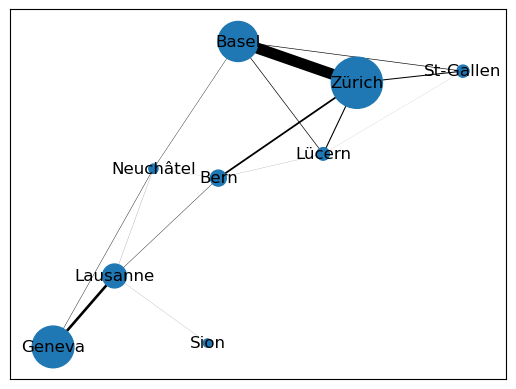

In [5]:
### Define the dynamics of the environment
### can be reused by all problems because env.reset() will reset the dynamics as well
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map
print(dyn.cities)
dyn.draw_map()

explain what you have done

### Seeds

In [6]:
seed = 42
seed2 = 53

seed3 = 78

## Question 1

#### Actions

- 'confinement': Represents imposing confinement or lockdown measures. False indicates it is not being imposed.
- 'isolation': Represents enforcing isolation measures. False indicates it is not being enforced.
- 'hospital': Represents admitting patients to hospitals. False indicates this action is not being taken.
- 'vaccinate': Represents administering vaccinations. False indicates no vaccinations are being given.

#### helper functions

In [7]:
from matplotlib.ticker import MultipleLocator

# parameters for action_preprocessor
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4

# parameter for observation_preprocessor
SCALE = 100

# Parse the logs
def parse_logs(log: Log, dyn: ModelDynamics):
    total = {p: np.array([getattr(l.total, p) for l in log]) for p in dyn.parameters}
    cities = {c: {p: np.array([getattr(l.city[c], p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
    actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}
    
    return total, cities, actions

# Plot 1: s[w], e[w], i[w], r[w], d[w] over time
def plot_all_totals(total: dict, axis: plt.Axes):
    # plt.figure()
    for y in total.values():
        axis.plot(y)
    axis.legend(total.keys())
    axis.set_xlabel('Weeks')
    axis.set_ylabel('Number of people in each state')
    axis.set_title('Full State')

# Plot 2: i[w], d[w] over time
def plot_infected_dead(total: dict, axis: plt.Axes):
    # plt.figure()
    for state in ['infected', 'dead']:
        axis.plot(total[state])
    axis.legend(['infected', 'dead'])
    axis.set_xlabel('Weeks')
    axis.set_ylabel('Number of people')
    axis.set_title('Observable State')

# Plot 3: i[w], d[w] over time, one subplot per city
def plot_infected_dead_per_city(dyn: ModelDynamics, cities: dict, axis: plt.Axes):
    [ax.plot(cities[c]['infected']) for c, ax in axis.items()]
    [ax.plot(cities[c]['dead']) for c, ax in axis.items()]
    [ax.set_ylabel(c) for c, ax in axis.items()]
    [ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in axis.items()]
    axis['Zürich'].set_xlabel('time (in weeks)')
    axis['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

# Plot 4: actions
def plot_actions(actions: np.array, axis: plt.Axes):
    axis.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')    
    axis.set_title('Actions')
    axis.set_xticks(np.arange(0, actions['confinement'].shape[0], 2))
    axis.set_yticks([0,1,2,3])
    axis.set_yticklabels(list(actions.keys()))
    axis.set_xlabel('time (in weeks)')

def hist_avg(ax, data, title):
    ymax = 50
    if title == 'deaths':
        x_range = (1000,200000)
        ax.set_xlabel('number of deaths in one episode')
    elif title == 'cumulative rewards': 
        x_range = (-300,300)
        ax.set_xlabel('cumulative reward in one episode')
    elif 'days' in title:
        x_range = (0,200)
        ax.set_xlabel('number of confined days in one episode')
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.set_ylabel('frequency')
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)


def plot_statistics(agent, env, save_path, title):  
  rewards, deaths, conf_days = evaluate_agent(agent, env, 50)

  fig, ax = plt.subplots(1, 3, figsize=(18,8))

  hist_avg(ax[0], deaths,'deaths')
  hist_avg(ax[1], rewards,'cumulative rewards')
  hist_avg(ax[2], conf_days,'confined days')

  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.suptitle(f'Evaluation Results on 50 Episodes: {title}')
  plt.savefig(save_path, format="pdf", bbox_inches="tight")
  plt.show()

  print(f'Average death number: {np.mean(deaths)}')
  print(f'Average cumulative reward: {np.mean(rewards)}')
  print(f'Average number of confined days: {np.mean(conf_days)}')


def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    

    if a == ACTION_CONFINE:
        action['confinement'] = True
    elif a == ACTION_ISOLATE:
        action['isolation'] = True
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = True
    elif a == ACTION_HOSPITAL:
        action['hospital'] = True
        
    return action

def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    ## similar to tutorial
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    out = torch.Tensor(np.stack((infected, dead))).flatten().unsqueeze(0)
    
    ## recommended by the project description to pass the observation tensor through (.)^0.25 to avoid very small values in the tensor
    return out**(0.25)

In [8]:
def evaluate_agent(agent: Agent, env: Env, n_episodes: int):
    global seed
    print(f'evaluating with seed: {seed}')
    torch.manual_seed(seed)

    num_total_deaths = []
    cumulative_reward = []
    num_total_confined_days = []


    for trial_i in tqdm(range(n_episodes), position=0, leave=True):
        log = []
        finished = False
        agent.reset()
        agent.epsilon = 0

        cum_R = 0
        total_deaths = 0
        num_confined_weeks = 0

        seed_local = torch.randint(0, 1000, (1,)).item()
        obs, info = env.reset(seed_local)
        
        for _ in range(30):
            if finished:
                break
            action, q_values = agent.act(obs, do_explore=False)
            obs, R, finished, info = env.step(action)
            log.append(info)
            cum_R += R
            # print(action)
            taken_action = env.action_preprocessor(action, env.dyn)
            # print(action, taken_action)
            if(taken_action['confinement']):
                num_confined_weeks += 1

        cumulative_reward.append(cum_R.item())
        num_total_deaths.append(info.total.dead)
        num_total_confined_days.append(num_confined_weeks * 7)
    
    return cumulative_reward, num_total_deaths, num_total_confined_days

In [9]:
def plot_one_episode(agent, env, save_path, episode_seed, title):
  """ Run the simulation """
  log = []
  finished = False
  torch.manual_seed(seed)
  obs, info = env.reset(episode_seed)

  print(f'running one episode with torch seed = {seed} and env seed = {episode_seed}')

  agent.reset()
  agent.epsilon = 0
  q_values_30 = []
  for _ in range(30):
      action, q_values = agent.act(obs, do_explore=False)
      obs, R, finished, info = env.step(action)
      log.append(info) # save the information dict for logging
      q_values_30.append(q_values)

  q_values_30 = torch.tensor(q_values_30)
      
  total, cities, actions = parse_logs(log, dyn)

  ##2.a
  fig = plt.figure(figsize=(14,10))
  ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
  ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
  ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
  ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
  ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
  ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

  #2.a.1
  plot_all_totals(total, ax_leftstate)

  #2.a.2
  plot_infected_dead(total, ax_leftobs)

  #2.a.3
  plot_infected_dead_per_city(dyn, cities, ax_right)

  #2.a.4
  plot_actions(actions, ax_leftactions)

  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.suptitle(title)
  plt.savefig(save_path, format="pdf", bbox_inches="tight")
  plt.show()

  return q_values_30

In [10]:
def action_preprocessor_factorized(a:int, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }

    a = a.squeeze()
    # print(a)
    if a[0] == 0:
        action['confinement'] = True
    if a[1] == 0:
        action['isolation'] = True
    if a[2] == 0:
        action['hospital'] = True
    if a[3] == 0:
        action['vaccinate'] = True

    return action

In [ ]:
NULL_ACTION = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
class NullAgent(Agent):
    def __init__(self, env:Env):
        """
        no mitigation agent
        """
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the routine for optimizing the model
        pass
    
    def reset(self,):
        # This should be called when the environment is reset
        pass

    def act(self, obs, do_explore=True):
      return NULL_ACTION, []

running one episode with torch seed = 42 and env seed = 42


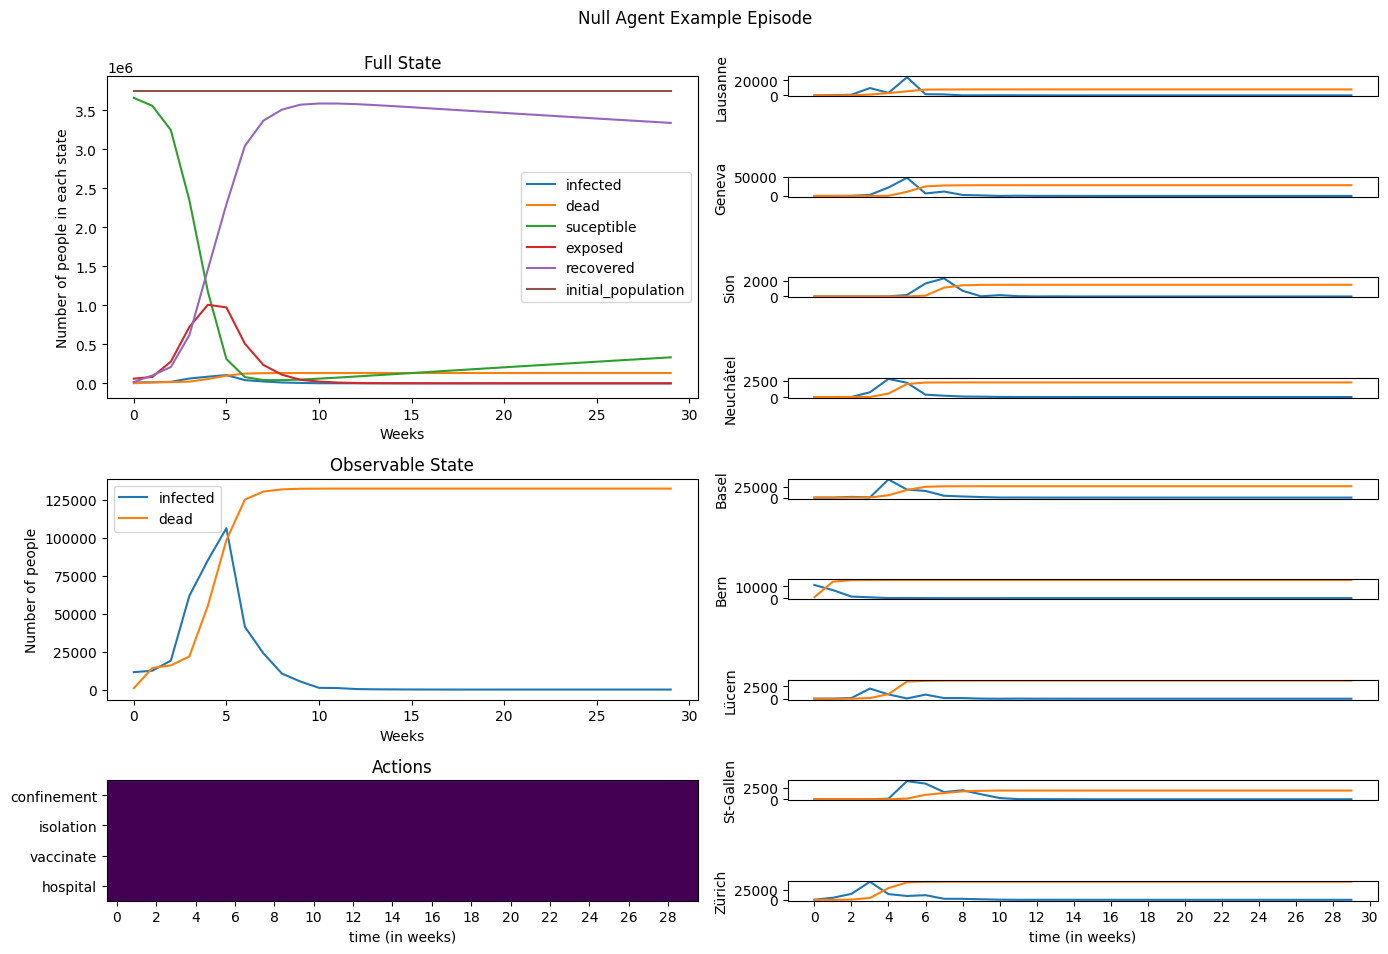

tensor([], size=(30, 0))

In [ ]:
env_1 = Env(  dyn, # We pass the dynamical model to the environment 
            action_space=None, # Here one could pass an openai gym action space that can then be sampled
            observation_space=None, # Here one could pass an openai gym obs space that can then be sampled
            action_preprocessor=action_preprocessor,
            )

agent = NullAgent(env_1)
plot_one_episode(agent, env_1, save_path="report_figs/1a.pdf", episode_seed=42, title="Null Agent Example Episode")

## Question 2

#### Part A

Implement Pr. Russo’s Policy as a python class (we recommend that you subclass the Agent abstract class provided with the project files, and as is demonstrated in the tutorial notebook). Run the epidemic simulation for one episode using Pr. Russo’s Policy to pick actions and produce four plots:

#### Helper functions

In [ ]:
class RussosAgent(Agent):
    def __init__(self,  env:Env,
                # Additionnal parameters to be added here
                ):
        """
        Pr. Russos' agent: Confines the whole country if the number of infected people
        is above 20,000 if not already done
        """
        self.week_counter = 0
        self.in_confinement = False
        self.env = env
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the routine for optimizing the model
        pass
    
    def reset(self,):
        # This should be called when the environment is reset
        self.week_counter = 0
        self.in_confinement = False
    
    ## do_explore is auxiliary here and for the reuse evaluate_agnet function
    def act(self, obs, do_explore=True):
        # this takes an observation and returns an action
        if self.in_confinement and self.week_counter < 4:
            self.week_counter += 1
            return 1, []
        elif self.in_confinement and self.week_counter >= 4:
            self.week_counter = 0
            self.in_confinement = False

        num_infected = obs.total.infected[-1]

        if num_infected > 20_000:
            self.in_confinement = True
            return 1, []
        else:
            return 0, []

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


running one episode with torch seed = 42 and env seed = 42


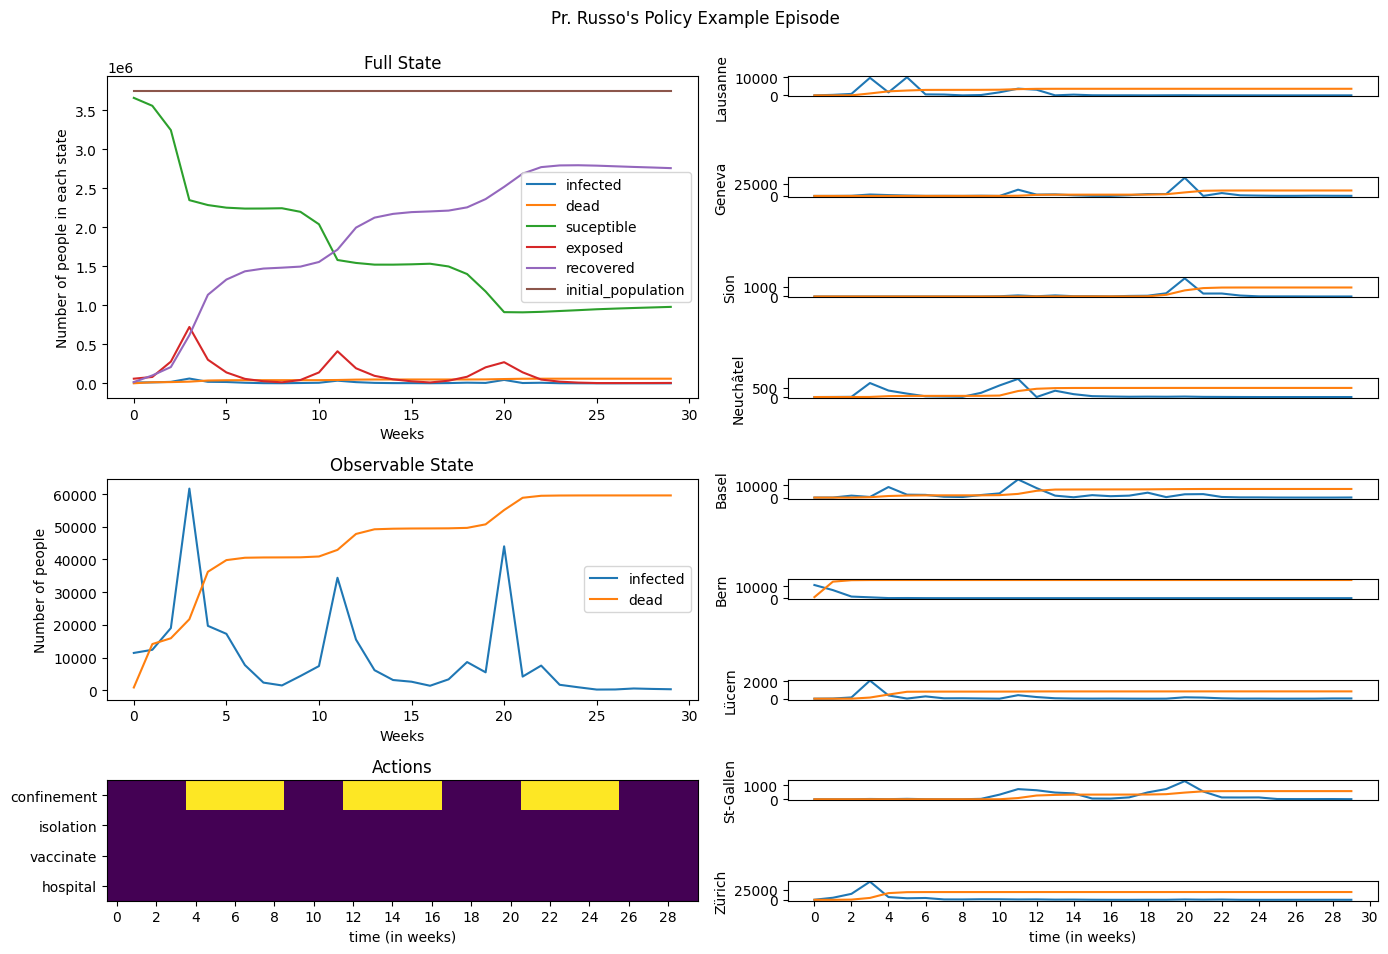

tensor([], size=(30, 0))

In [ ]:
env_2 = Env(  dyn, # We pass the dynamical model to the environment 
            action_space=None, # Here one could pass an openai gym action space that can then be sampled
            observation_space=None, # Here one could pass an openai gym obs space that can then be sampled
            action_preprocessor=action_preprocessor,
            )

agent = RussosAgent(env_2)
plot_one_episode(agent, env_2, save_path="report_figs/2a.pdf", episode_seed=42, title="Pr. Russo's Policy Example Episode")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


evaluating with seed: 42


100%|██████████| 50/50 [00:55<00:00,  1.11s/it]


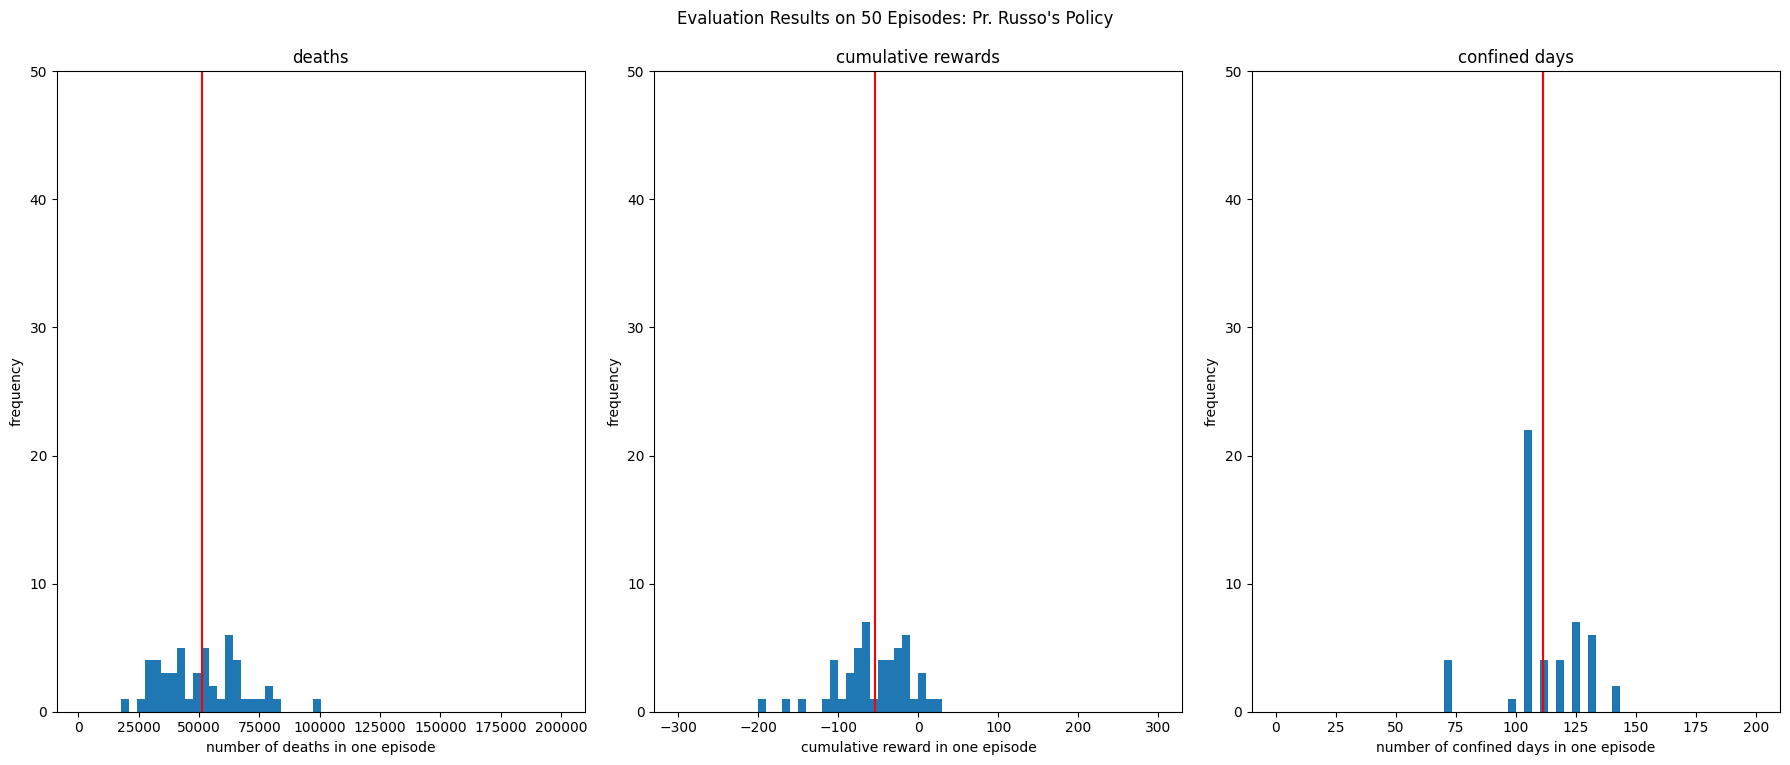

Average death number: 51079.26
Average cumulative reward: -54.80609775066376
Average number of confined days: 111.44


In [ ]:
plot_statistics(agent, env_2, save_path="report_figs/2b.pdf", title="Pr. Russo's Policy")

# Question 3

## 3.a

In [11]:
env_3 = Env(  dyn,
            action_space=spaces.Discrete(2),
            observation_space=None,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

env_3_eval = Env(  dyn,
            action_space=spaces.Discrete(2),
            observation_space=None,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

In [12]:
from collections import namedtuple, deque

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        random_indices = torch.randint(0, len(self.memory), (batch_size,))
        return [self.memory[i] for i in random_indices]

    def __len__(self):
        return len(self.memory)

In [13]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.hidden_layer_1 = nn.Linear(n_observations, 64)
        self.hidden_layer_2 = nn.Linear(64, 32)
        self.hidden_layer_3 = nn.Linear(32, 16)
        self.output_layer = nn.Linear(16, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = self.hidden_layer_1(x)
        x = F.relu(x)
        x = self.hidden_layer_2(x)
        x = F.relu(x)
        x = self.hidden_layer_3(x)
        x = F.relu(x)
        x = self.output_layer(x)

        return x

In [55]:
class DQNAgent(Agent):
    def __init__(self,
                env:Env,
                env_eval: Env,
                seed:int,
                # Additionnal parameters to be added here
                n_actions:int=2,
                eps_start:float=0.7,
                eps_end:float=0.7,
                num_episodes:int=500,
                num_episodes_eval:int=20,
                lr=5e-3,
                ):
        """
        DQN Agent
        """
        # BATCH_SIZE is the number of transitions sampled from the replay buffer
        # GAMMA is the discount factor as mentioned in the previous section
        # EPS_START is the starting value of epsilon
        # EPS_END is the final value of epsilon
        # EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
        # TAU is the update rate of the target network
        # LR is the learning rate of the ``AdamW`` optimizer
        self.BATCH_SIZE = 128
        self.GAMMA = 0.9
        self.EPS_START = eps_start
        self.EPS_END = eps_end
        self.TAU = 5e-3
        self.LR = lr
        print(f'using LR={self.LR}')
        self.num_episodes = num_episodes
        self.num_episodes_eval = num_episodes_eval

        self.env = env
        self.env_eval = env_eval
        self.seed = seed
        # self.env.action_space.seed(self.seed)

        # Get the number of state observations
        torch.manual_seed(self.seed)
        torch.use_deterministic_algorithms(True)

        print(f'network with seed = {self.seed}')
        obs, info = self.env.reset(0)
        n_observations = obs.flatten().shape[0]

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(f'using device: {self.device}')

        self.policy_net = DQN(n_observations, n_actions).to(self.device)
        self.target_net = DQN(n_observations, n_actions).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.LR, amsgrad=True)
        self.memory = ReplayMemory(20_000)

        self.steps_done = 0

        self.n_actions = n_actions

    def load_model(self, savepath="./models/", device='cpu'):
        # This is where one would define the routine for loading a pre-trained model
        self.target_net.load_state_dict(torch.load(savepath + "target_net.pt", map_location=torch.device(device)))
        self.policy_net.load_state_dict(torch.load(savepath + "policy_net.pt", map_location=torch.device(device)))
        
    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        torch.save(agent.policy_net.state_dict(), savepath + "policy_net.pt")
        torch.save(agent.target_net.state_dict(), savepath + "target_net.pt")
        

    def train(self, save_path):
        best_cumulative_reward = float('-inf')
        training_trace = []
        evaluation_trace = []
        losses = []
        for trial_i in tqdm(range(self.num_episodes), position=0, leave=True):
            # Initialize the environment and get it's state
            episode_seed = torch.randint(0, 1000, (1,)).item()
            # print('episode_seed:', episode_seed)
            obs, info = self.env.reset(episode_seed)
            # obs = torch.tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)

            if (trial_i%50==0) or (trial_i == self.num_episodes-1):
              # Evaluate the agent
              # print(f'self.steps_done 1:{self.steps_done}')
              current_steps_done = self.steps_done
              cumulative_reward, num_total_deaths, num_total_confined_days = evaluate_agent(agent, self.env_eval, self.num_episodes_eval)
              # print(f'self.steps_done 2:{self.steps_done}')
              self.steps_done = current_steps_done
              # print(f'self.steps_done 3:{self.steps_done}')
              average_cumulative_reward = np.mean(cumulative_reward)
              evaluation_trace.append(average_cumulative_reward)
              print('eval mean cumulative reward:', average_cumulative_reward)
              if np.mean(cumulative_reward) > best_cumulative_reward:
                  best_cumulative_reward = np.mean(cumulative_reward)
                  self.save_model(save_path)
                  print(f'saved model checkpoint!')


            cum_R = 0

            for t in range(30):
                if obs == None:
                    break
                action, q_values = self.act(obs)

                ## I changed this part from the original code (it was expecting a truncate flag an oring that with the terminate flag)
                next_obs, reward, terminated, info  = self.env.step(action)
                cum_R += reward
                reward = torch.tensor([reward], device=self.device)
                # done = terminated

                # Store the transition in memory
                self.memory.push(obs, action, next_obs, reward)

                # Move to the next state
                obs = next_obs
            
                # Perform one step of the optimization (on the policy network)
                self.optimize_model(losses)

            #For each episode, log the cumulative reward:
            training_trace.append(cum_R.item())

            if trial_i%5==4:
              # Soft update of the target network's weights
              # θ′ ← τ θ + (1 −τ )θ′
              target_net_state_dict = self.target_net.state_dict()
              policy_net_state_dict = self.policy_net.state_dict()
              # print(f'updating target net: episode {trial_i}')
              for key in policy_net_state_dict:
                  # target_net_state_dict[key] = policy_net_state_dict[key]*self.TAU + target_net_state_dict[key]*(1-self.TAU)
                  target_net_state_dict[key] = policy_net_state_dict[key]
              self.target_net.load_state_dict(target_net_state_dict)

            self.steps_done += 1

        return training_trace, evaluation_trace, losses


    def optimize_model(self, losses):
        # This is where one would define the optimization step of an RL algorithm
        if len(self.memory) < self.BATCH_SIZE:
            return
        transitions = self.memory.sample(self.BATCH_SIZE)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=self.device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        # policy_net_input = state_batch.flatten(start_dim=1).to(device)
        policy_net_input = state_batch.to(self.device)
        policy_net_output = self.policy_net(policy_net_input)
        state_action_values = policy_net_output.gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.BATCH_SIZE, device=self.device)
        with torch.no_grad():
            # target_net_input = non_final_next_states.flatten(start_dim=1).to(self.device)
            target_net_input = non_final_next_states.to(self.device)
            target_net_output = self.target_net(target_net_input)
            next_state_values[non_final_mask] = target_net_output.max(1)[0]
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()
        return 0
    
    def reset(self):
        #reset the inner state of the agent
        self.steps_done = 0

    
    def act(self, obs, do_explore=True):
        # this takes an observation and returns an action
        sample = torch.rand(1)
        # eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * math.exp(-1. * self.steps_done / self.EPS_DECAY)
        eps_threshold = max(self.EPS_END,  self.EPS_START * (1 - self.steps_done / self.num_episodes))

        if do_explore and sample <= eps_threshold:
            return torch.tensor([[torch.randint(0, self.n_actions, (1,))]], device=self.device, dtype=torch.long), []
        else:
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                # dqn_input = obs.flatten().to(self.device)
                dqn_input = obs.to(self.device)
                dqn_output = self.policy_net(dqn_input)
                selected_action = torch.tensor([[dqn_output.argmax()]]).to(self.device)
                q_values = dqn_output.squeeze(0).tolist()
                # print('selected action: ', selected_action)
                return selected_action, q_values

In [56]:
# import os
# os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:2"

In [ ]:
agent = DQNAgent(env_3, env_3_eval, seed, n_actions=2, eps_start=0.7, eps_end=0.7, num_episodes=500, num_episodes_eval=20, lr=5e-3)
training_trace_3a_1, evaluation_trace_3a_1, losses_3a_1 = agent.train(save_path="./models/eps_fixed_1/")

np.savetxt('report_figs/3a_training_1.csv', training_trace_3a_1, delimiter=',')
np.savetxt('report_figs/3a_evaluation_1.csv', evaluation_trace_3a_1, delimiter=',')
np.savetxt('report_figs/3a_losses_1.csv', losses_3a_1, delimiter=',')

In [ ]:
agent = DQNAgent(env_3, env_3_eval, seed2, n_actions=2, eps_start=0.7, eps_end=0.7, num_episodes=500, num_episodes_eval=20)
training_trace_3a_2, evaluation_trace_3a_2, losses_3a_2 = agent.train(save_path="./models/eps_fixed_2/")

np.savetxt('report_figs/3a_training_2.csv', training_trace_3a_2, delimiter=',')
np.savetxt('report_figs/3a_evaluation_2.csv', evaluation_trace_3a_2, delimiter=',')
np.savetxt('report_figs/3a_losses_2.csv', losses_3a_2, delimiter=',')

In [ ]:
agent = DQNAgent(env_3, env_3_eval, seed3, n_actions=2, eps_start=0.7, eps_end=0.7, num_episodes=500, num_episodes_eval=20)
training_trace_3a_3, evaluation_trace_3a_3, losses_3a_3 = agent.train(save_path="./models/eps_fixed_3/")

np.savetxt('report_figs/3a_training_3.csv', training_trace_3a_3, delimiter=',')
np.savetxt('report_figs/3a_evaluation_3.csv', evaluation_trace_3a_3, delimiter=',')
np.savetxt('report_figs/3a_losses_3.csv', losses_3a_3, delimiter=',')

In [57]:
training_trace_3a_1 = np.genfromtxt('report_figs/3a_training_1.csv', delimiter=',', skip_header=0)
training_trace_3a_2 = np.genfromtxt('report_figs/3a_training_2.csv', delimiter=',', skip_header=0)
training_trace_3a_3 = np.genfromtxt('report_figs/3a_training_3.csv', delimiter=',', skip_header=0)

evaluation_trace_3a_1 = np.genfromtxt('report_figs/3a_evaluation_1.csv', delimiter=',', skip_header=0)
evaluation_trace_3a_2 = np.genfromtxt('report_figs/3a_evaluation_2.csv', delimiter=',', skip_header=0)
evaluation_trace_3a_3 = np.genfromtxt('report_figs/3a_evaluation_3.csv', delimiter=',', skip_header=0)

losses_3a_1 = np.genfromtxt('report_figs/3a_losses_1.csv', delimiter=',')
losses_3a_2 = np.genfromtxt('report_figs/3a_losses_2.csv', delimiter=',')
losses_3a_3 = np.genfromtxt('report_figs/3a_losses_3.csv', delimiter=',')
#####################################################################################
training_trace_3b_1 = np.genfromtxt('report_figs/3b_training_1.csv', delimiter=',', skip_header=0)
training_trace_3b_2 = np.genfromtxt('report_figs/3b_training_2.csv', delimiter=',', skip_header=0)
training_trace_3b_3 = np.genfromtxt('report_figs/3b_training_3.csv', delimiter=',', skip_header=0)

evaluation_trace_3b_1 = np.genfromtxt('report_figs/3b_evaluation_1.csv', delimiter=',', skip_header=0)
evaluation_trace_3b_2 = np.genfromtxt('report_figs/3b_evaluation_2.csv', delimiter=',', skip_header=0)
evaluation_trace_3b_3 = np.genfromtxt('report_figs/3b_evaluation_3.csv', delimiter=',', skip_header=0)

losses_3b_1 = np.genfromtxt('report_figs/3b_losses_1.csv', delimiter=',', skip_header=0)
losses_3b_2 = np.genfromtxt('report_figs/3b_losses_2.csv', delimiter=',', skip_header=0)
losses_3b_3 = np.genfromtxt('report_figs/3b_losses_3.csv', delimiter=',', skip_header=0)

### Plotting the training trace

In [58]:
## Choose best run:

print(f'last evaluation reward trace 1 = {max(evaluation_trace_3a_1)}')
print(f'last evaluation reward trace 2 = {max(evaluation_trace_3a_2)}')
print(f'last evaluation reward trace 3 = {max(evaluation_trace_3a_3)}')

# choose trace3
# last evaluation reward trace 1 = 36.62702350616455
# last evaluation reward trace 2 = 33.20492067337036
# last evaluation reward trace 3 = 41.29023942947388

last evaluation reward trace 1 = 36.62702350616455
last evaluation reward trace 2 = 33.20492067337036
last evaluation reward trace 3 = 41.29023942947388


### Plot 3 episodes

In [88]:
def plot_traces(trc1, trc2, trc3, eval_trc1, eval_trc2, eval_trc3, title):
  plt.scatter(x = torch.arange(500), y=trc1, color='skyblue', label='Training trace 1')
  plt.scatter(x = torch.arange(500), y=trc2, color='green', label='Training trace 2')
  plt.scatter(x = torch.arange(500), y=trc3, color='orange', label='Training trace 3')

  plt.xlabel('training episode')
  plt.ylabel('cumulative reward')

# def plot_evaluation_traces(trc1, trc2, trc3, ax, title):
  eval_traces = torch.stack([torch.tensor(eval_trc1), torch.tensor(eval_trc2), torch.tensor(eval_trc3)], dim=1)
  eval_traces = eval_traces.mean(dim=1)

  plt.plot(torch.arange(len(eval_traces)) * 50, eval_traces, label="Evaluation trace", color='red')
  plt.xlabel('training episode')
  plt.ylabel('cumulative reward')

  plt.legend()
  plt.title(title)

  # ylim_min = (min(eval_traces) // 10) * 10 - 10
  # ylim_max = (max(eval_traces) // 10) * 10 + 10
  # ax.set_yticks(torch.arange(ylim_min, ylim_max, 10))

In [89]:
agent = DQNAgent(env_3, env_3_eval, seed, eps_start=0.7, eps_end=0.7, num_episodes=500)
agent.load_model(savepath="./models/eps_fixed_3/")

using LR=0.005
network with seed = 42
using device: cpu


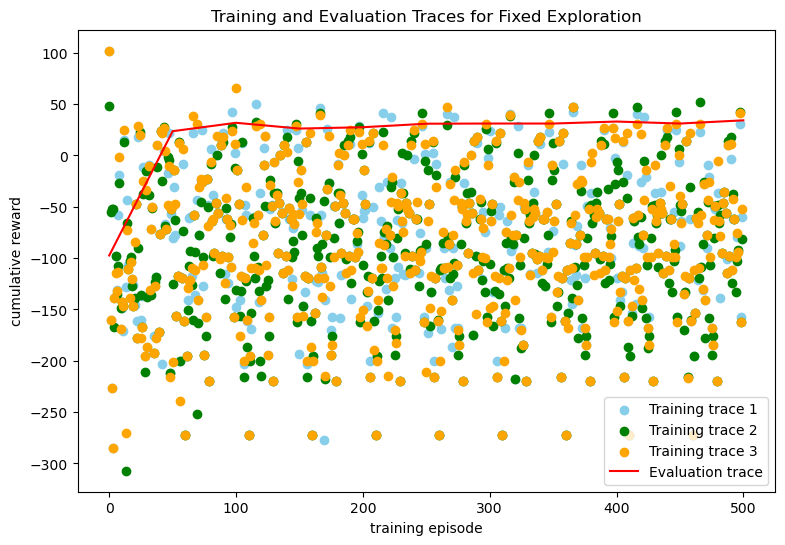

In [93]:
fig, axs = plt.subplots(1, 1, figsize=(9,6))

plot_traces(training_trace_3a_1, training_trace_3a_2, training_trace_3a_3, 
            evaluation_trace_3a_1,
            evaluation_trace_3a_2,
            evaluation_trace_3a_3,
            title="Training and Evaluation Traces for Fixed Exploration")
# plot_evaluation_traces(evaluation_trace_3a_1, evaluation_trace_3a_2, evaluation_trace_3a_3, axs[1], title="Evaluation traces with fixed exploration")
plt.savefig('report_figs/3b_train_eval_traces.pdf', format="pdf", bbox_inches="tight")
plt.show()

running one episode with torch seed = 42 and env seed = 42


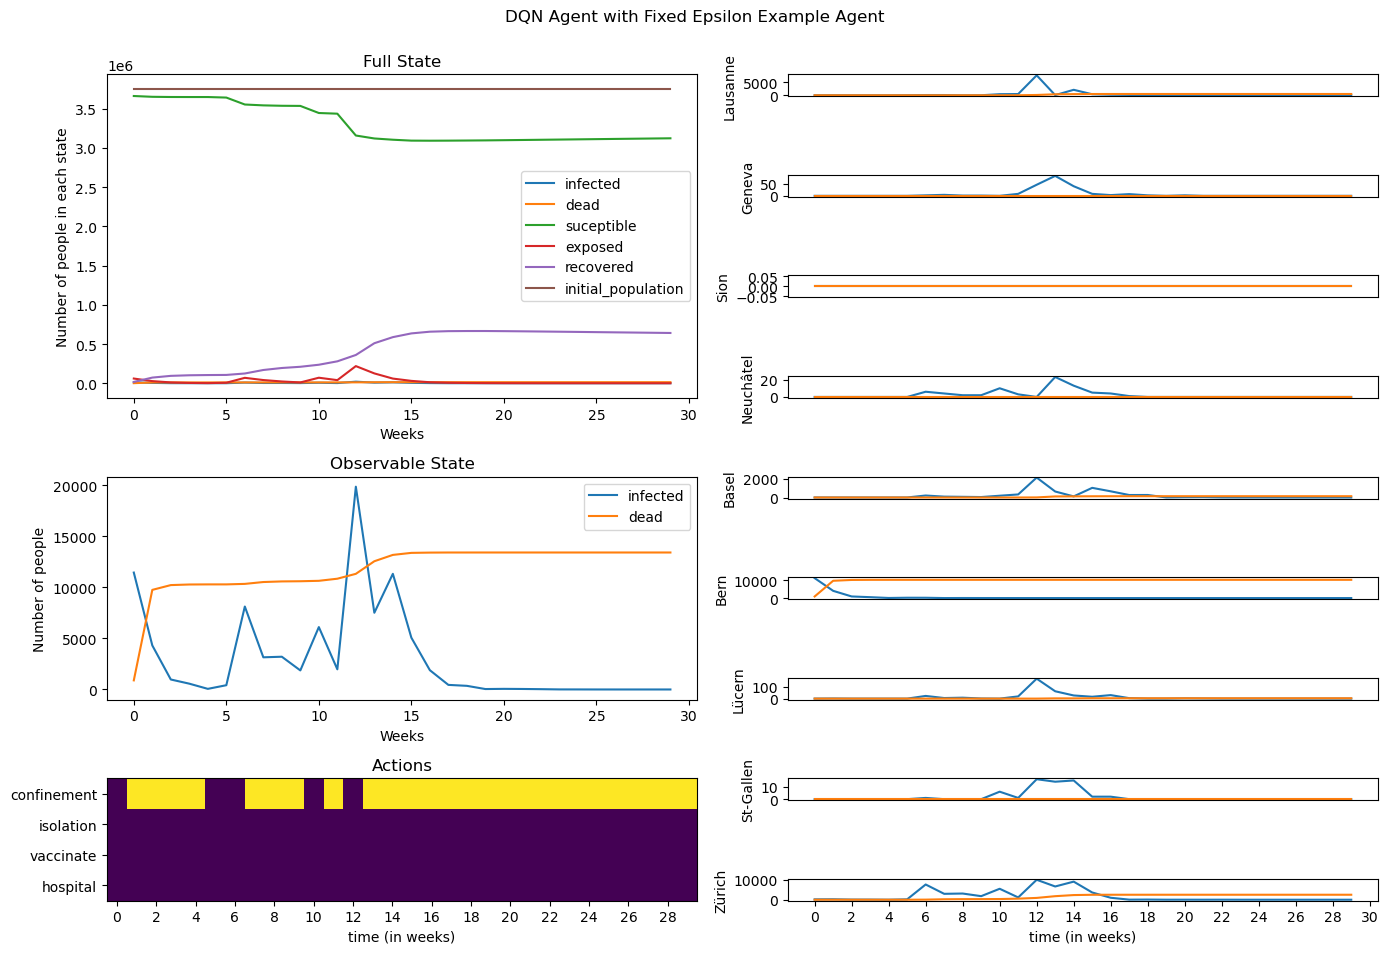

In [63]:
_ = plot_one_episode(agent, env_3_eval, save_path="report_figs/3a_episode_1.pdf", episode_seed=42, title="DQN Agent with Fixed Epsilon Example Agent")

running one episode with torch seed = 42 and env seed = 43


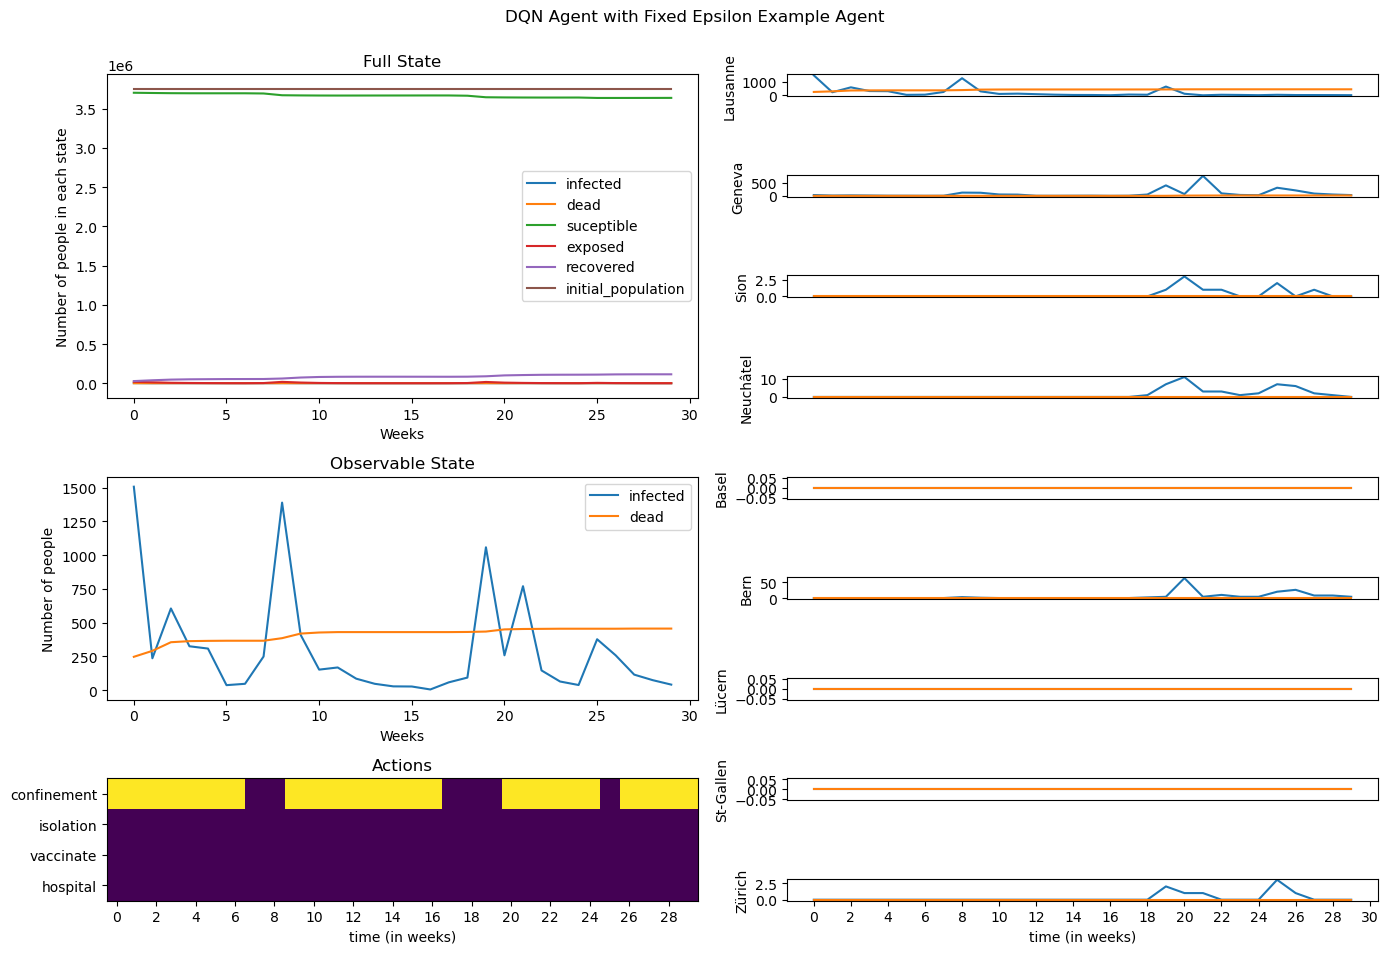

In [64]:
_ = plot_one_episode(agent, env_3_eval, save_path="report_figs/3a_sample_episode.pdf", episode_seed=43, title="DQN Agent with Fixed Epsilon Example Agent")

running one episode with torch seed = 42 and env seed = 44


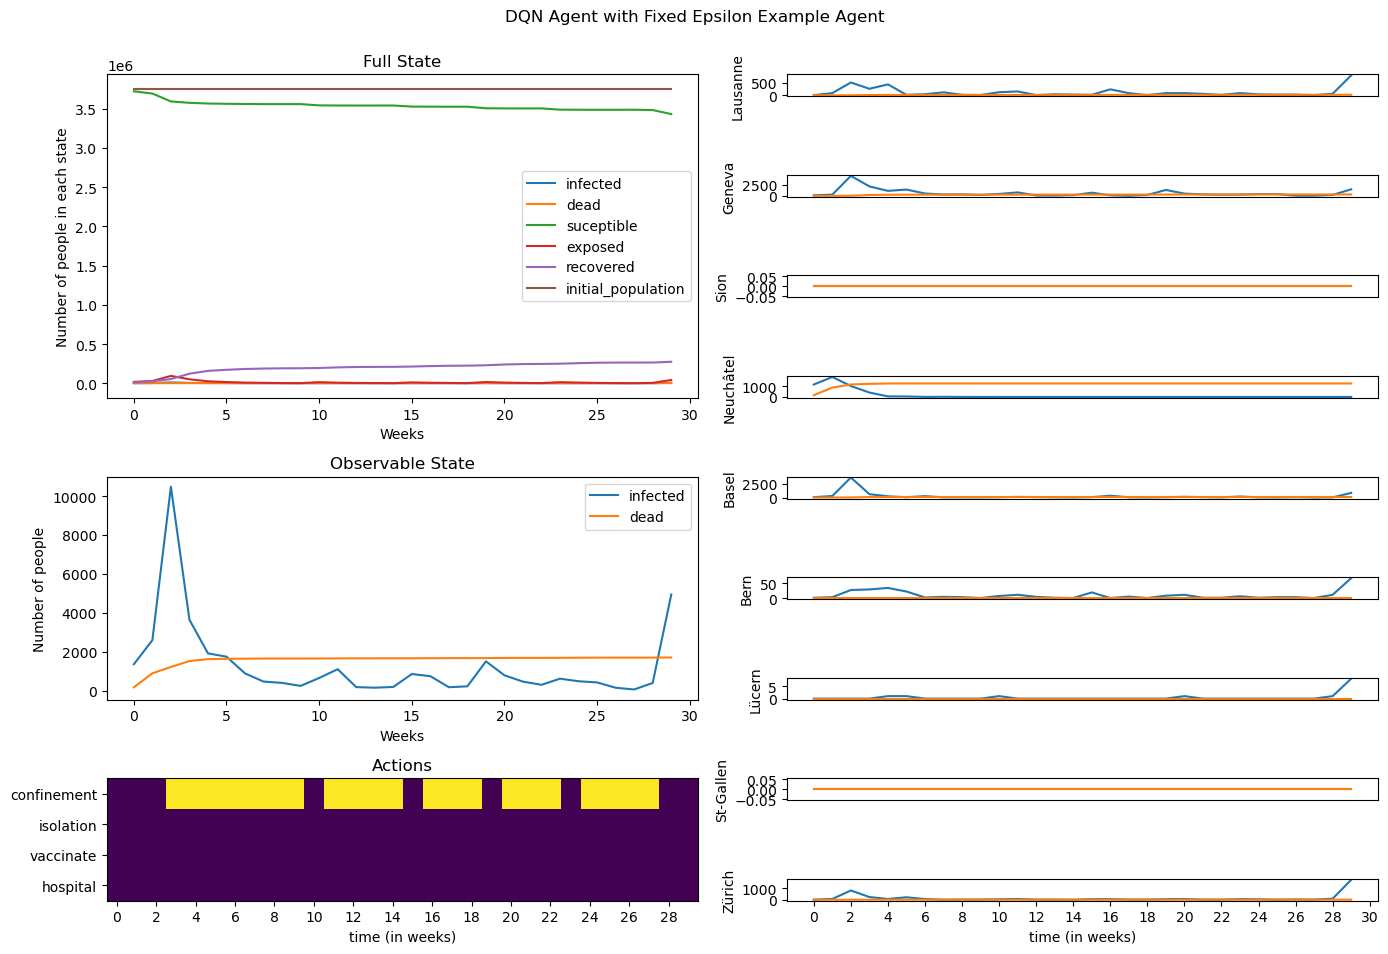

In [65]:
_ = plot_one_episode(agent, env_3_eval, save_path="report_figs/3a_episode_3.pdf", episode_seed=44, title="DQN Agent with Fixed Epsilon Example Agent")

### 3.b

In [ ]:
agent = DQNAgent(env_3, env_3_eval, seed, n_actions=2, eps_start=0.7, eps_end=0.2, num_episodes=500, num_episodes_eval=20)

training_trace_3b_1, evaluation_trace_3b_1, losses_3b_1 = agent.train(save_path="./models/eps_decay_1/")

np.savetxt('report_figs/3b_training_1.csv', training_trace_3b_1, delimiter=',')
np.savetxt('report_figs/3b_evaluation_1.csv', evaluation_trace_3b_1, delimiter=',')
np.savetxt('report_figs/3b_losses_1.csv', losses_3b_1, delimiter=',')

In [ ]:
agent = DQNAgent(env_3, env_3_eval, seed2, n_actions=2, eps_start=0.7, eps_end=0.2, num_episodes=500, num_episodes_eval=20)

training_trace_3b_2, evaluation_trace_3b_2, losses_3b_2 = agent.train(save_path="./models/eps_decay_2/")

np.savetxt('report_figs/3b_training_2.csv', training_trace_3b_2, delimiter=',')
np.savetxt('report_figs/3b_evaluation_2.csv', evaluation_trace_3b_2, delimiter=',')
np.savetxt('report_figs/3b_losses_2.csv', losses_3b_2, delimiter=',')


In [ ]:
agent = DQNAgent(env_3, env_3_eval, seed3, n_actions=2, eps_start=0.7, eps_end=0.2, num_episodes=500, num_episodes_eval=20)

training_trace_3b_3, evaluation_trace_3b_3, losses_3b_3 = agent.train(save_path="./models/eps_decay_3/")

np.savetxt('report_figs/3b_training_3.csv', training_trace_3b_3, delimiter=',')
np.savetxt('report_figs/3b_evaluation_3.csv', evaluation_trace_3b_3, delimiter=',')
np.savetxt('report_figs/3b_losses_3.csv', losses_3b_3, delimiter=',')

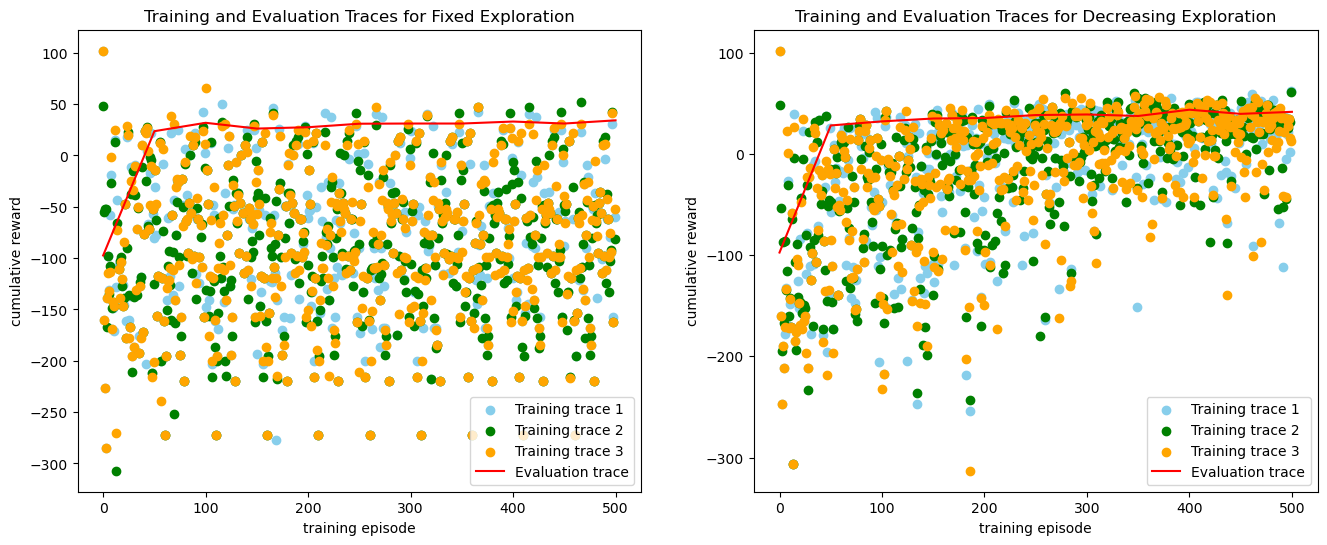

In [96]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))

# choose the first plot
plt.subplot(1, 2, 1)
plot_traces(training_trace_3a_1, training_trace_3a_2, training_trace_3a_3, 
            evaluation_trace_3a_1,
            evaluation_trace_3a_2,
            evaluation_trace_3a_3,
            title="Training and Evaluation Traces for Fixed Exploration")

plt.subplot(1, 2, 2)
plot_traces(training_trace_3b_1, training_trace_3b_2, training_trace_3b_3, 
            evaluation_trace_3b_1,
            evaluation_trace_3b_2,
            evaluation_trace_3b_3,
            title="Training and Evaluation Traces for Decreasing Exploration")
# plot_evaluation_traces(evaluation_trace_3a_1, evaluation_trace_3a_2, evaluation_trace_3a_3, axs[1], title="Evaluation traces with fixed exploration")
plt.savefig('report_figs/3b_train_eval_traces_all.pdf', format="pdf", bbox_inches="tight")
plt.show()

In [69]:
## Choose best run:

print(f'best evaluation reward trace 1 3a = {max(evaluation_trace_3a_1)}')
print(f'best evaluation reward trace 2 3a = {max(evaluation_trace_3a_2)}')
print(f'best evaluation reward trace 3 3a = {max(evaluation_trace_3a_3)}')

print(f'best evaluation reward trace 1 3b = {max(evaluation_trace_3b_1)}')
print(f'best evaluation reward trace 2 3b = {max(evaluation_trace_3b_2)}')
print(f'best evaluation reward trace 3 3b = {max(evaluation_trace_3b_3)}')

# best evaluation reward trace 1 3a = 36.62702350616455
# best evaluation reward trace 2 3a = 33.20492067337036
# best evaluation reward trace 3 3a = 41.29023942947388
# best evaluation reward trace 1 3b = 46.37634744644165
# best evaluation reward trace 2 3b = 44.896693801879884
# best evaluation reward trace 3 3b = 43.456010246276854

best evaluation reward trace 1 3a = 36.62702350616455
best evaluation reward trace 2 3a = 33.20492067337036
best evaluation reward trace 3 3a = 41.29023942947388
best evaluation reward trace 1 3b = 46.37634744644165
best evaluation reward trace 2 3b = 44.896693801879884
best evaluation reward trace 3 3b = 43.456010246276854


In [71]:
agent = DQNAgent(env_3, env_3_eval, seed, eps_start=0.7, eps_end=0.2, num_episodes=500)
agent.load_model(savepath="./models/eps_decay_1/")

using LR=0.005
network with seed = 42
using device: cpu


evaluating with seed: 42


100%|██████████| 50/50 [00:43<00:00,  1.16it/s]


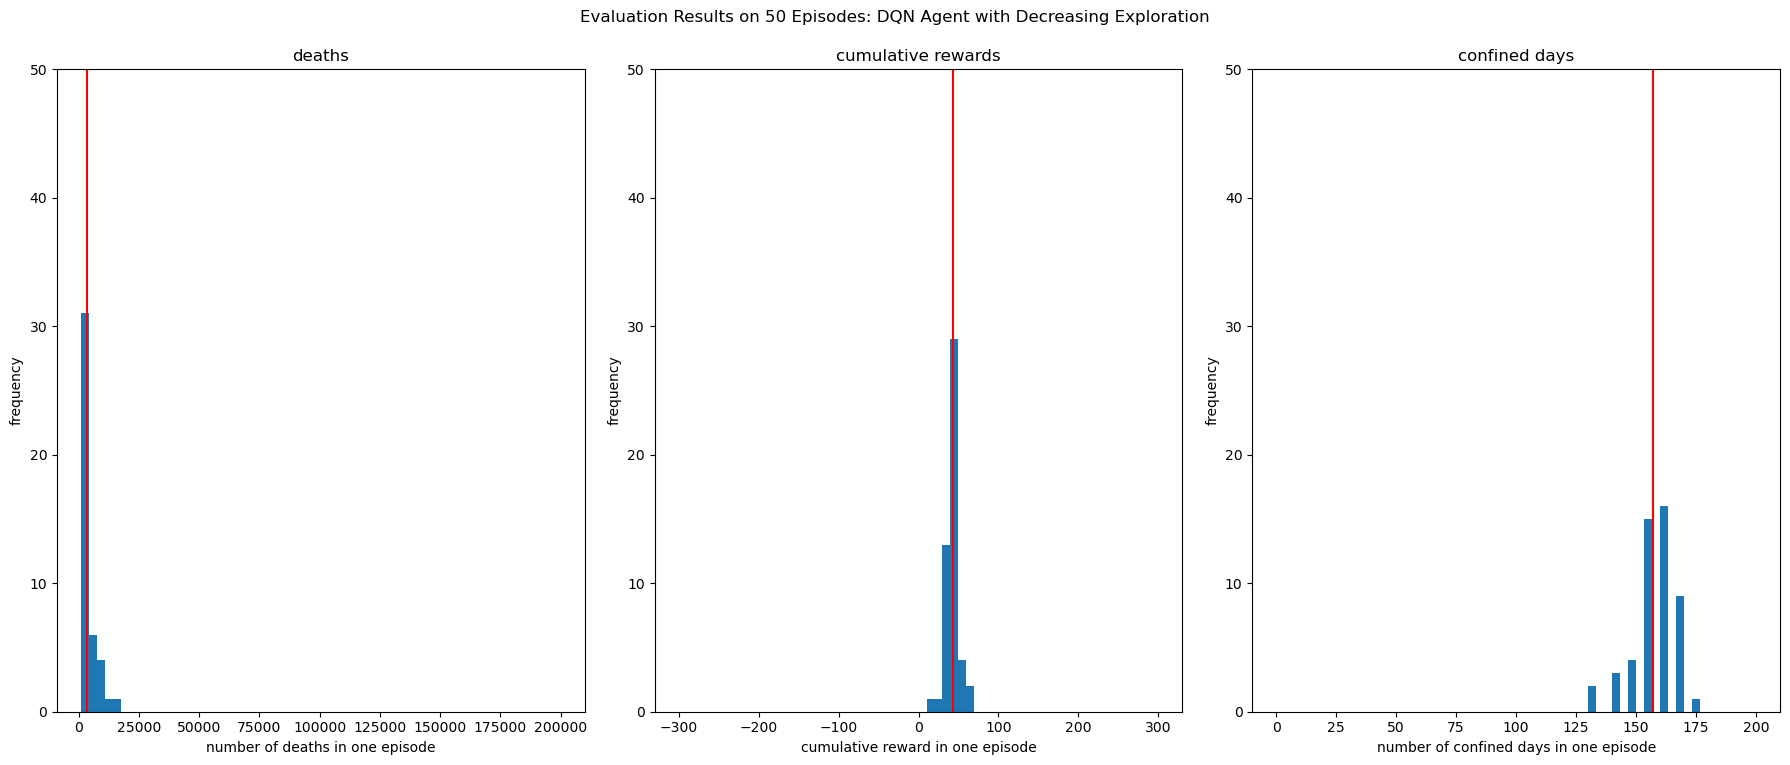

Average death number: 3496.52
Average cumulative reward: 43.169623374938965
Average number of confined days: 156.94


In [72]:
plot_statistics(agent, env_3_eval, "report_figs/3c.pdf", title="DQN Agent with Decreasing Exploration")

## Question 4.1: Toggle Action Space

In [45]:
def action_preprocessor_toggle(a:torch.Tensor, dyn:ModelDynamics):
    previous_action = dyn.get_action()

    action = previous_action.copy()
    # Toogle the corresponding action
    if a+1 == ACTION_CONFINE:
        action['confinement'] = not previous_action['confinement']
    elif a+1 == ACTION_ISOLATE:
        action['isolation'] = not previous_action['isolation']
    elif a+1 == ACTION_VACCINATE:
        action['vaccinate'] = not previous_action['vaccinate']
    elif a+1 == ACTION_HOSPITAL:
        action['hospital'] = not previous_action['hospital']
        
    return action


def observation_preprocessor_toggle(obs: Observation, dyn:ModelDynamics):
    ## similar to tutorial
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    # confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    out = torch.Tensor(np.stack((infected, dead)))
    
    ## Add the current action states to the observation
    action = dyn.get_action()
    out = torch.cat((out.flatten(), torch.Tensor([action['confinement'], action['isolation'], action['vaccinate'], action['hospital']])))
    out = out.unsqueeze(0)
    ## recommended by the project description to pass the observation tensor through (.)^0.25 to avoid very small values in the tensor
    return out**(0.25)

In [46]:
env_41 = Env(  dyn,
            action_space=spaces.Discrete(5),
            observation_space=None,
            action_preprocessor=action_preprocessor_toggle,
            observation_preprocessor=observation_preprocessor_toggle,
            )

env_41_eval = Env(  dyn,
            action_space=spaces.Discrete(5),
            observation_space=None,
            action_preprocessor=action_preprocessor_toggle,
            observation_preprocessor=observation_preprocessor_toggle,
            )

In [ ]:
agent = DQNAgent(env_41, env_41_eval, seed, n_actions=5, eps_start=0.7, eps_end=0.2, num_episodes=500, num_episodes_eval=20, lr=1e-3)

training_trace_41b_1, evaluation_trace_41b_1, losses_41b_1 = agent.train(save_path="./models/toggle_1/")

np.savetxt('report_figs/41b_training_1.csv', training_trace_41b_1, delimiter=',')
np.savetxt('report_figs/41b_evaluation_1.csv', evaluation_trace_41b_1, delimiter=',')
np.savetxt('report_figs/41b_losses_1.csv', losses_41b_1, delimiter=',')

using LR=0.001
network with seed = 42
using device: cpu


  0%|          | 0/500 [00:00<?, ?it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:17<00:00,  1.15it/s]


eval mean cumulative reward: -83.08468704223633
saved model checkpoint!


 10%|█         | 50/500 [01:17<08:50,  1.18s/it] 

evaluating with seed: 42


100%|██████████| 20/20 [00:17<00:00,  1.15it/s]


eval mean cumulative reward: -73.62281584739685
saved model checkpoint!


 20%|██        | 100/500 [02:23<05:32,  1.20it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


eval mean cumulative reward: -59.87431230545044
saved model checkpoint!


 30%|███       | 150/500 [03:23<04:46,  1.22it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


eval mean cumulative reward: 6.3955124616622925
saved model checkpoint!


 40%|████      | 200/500 [04:26<04:18,  1.16it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


eval mean cumulative reward: 12.717809510231017
saved model checkpoint!


 50%|█████     | 250/500 [05:30<03:24,  1.22it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


eval mean cumulative reward: 14.20826985836029
saved model checkpoint!


 60%|██████    | 300/500 [06:32<02:43,  1.23it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


eval mean cumulative reward: 18.973885416984558
saved model checkpoint!


 70%|███████   | 350/500 [07:31<02:06,  1.18it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


eval mean cumulative reward: 16.496716767549515


 80%|████████  | 400/500 [08:28<01:21,  1.23it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


eval mean cumulative reward: 6.493974208831787


 90%|█████████ | 450/500 [09:25<00:41,  1.19it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


eval mean cumulative reward: 19.34732096195221
saved model checkpoint!


100%|█████████▉| 499/500 [10:21<00:00,  1.20it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


eval mean cumulative reward: 32.59561207294464
saved model checkpoint!


100%|██████████| 500/500 [10:36<00:00,  1.27s/it]


In [ ]:
agent = DQNAgent(env_41, env_41_eval, seed2, n_actions=5, eps_start=0.7, eps_end=0.2, num_episodes=500, num_episodes_eval=20, lr=1e-3)

training_trace_41b_2, evaluation_trace_41b_2, losses_41b_2 = agent.train(save_path="./models/toggle_2/")

np.savetxt('report_figs/41b_training_2.csv', training_trace_41b_2, delimiter=',')
np.savetxt('report_figs/41b_evaluation_2.csv', evaluation_trace_41b_2, delimiter=',')
np.savetxt('report_figs/41b_losses_2.csv', losses_41b_2, delimiter=',')

using LR=0.001
network with seed = 53
using device: cpu


  0%|          | 0/500 [00:00<?, ?it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


eval mean cumulative reward: -132.2909091949463
saved model checkpoint!


 10%|█         | 50/500 [00:56<06:08,  1.22it/s] 

evaluating with seed: 42


100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


eval mean cumulative reward: -73.41910152435302
saved model checkpoint!


 20%|██        | 100/500 [01:52<05:35,  1.19it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


eval mean cumulative reward: -2.0119811058044434
saved model checkpoint!


 30%|███       | 150/500 [02:57<04:56,  1.18it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


eval mean cumulative reward: 19.858859992027284
saved model checkpoint!


 40%|████      | 200/500 [03:54<03:57,  1.26it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


eval mean cumulative reward: 22.321326446533202
saved model checkpoint!


 50%|█████     | 250/500 [05:03<04:42,  1.13s/it]

evaluating with seed: 42


100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


eval mean cumulative reward: 7.812597870826721


 60%|██████    | 300/500 [06:05<02:48,  1.19it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


eval mean cumulative reward: 18.885429358482362


 70%|███████   | 350/500 [07:05<02:14,  1.12it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


eval mean cumulative reward: 24.904411125183106
saved model checkpoint!


 80%|████████  | 400/500 [08:01<01:21,  1.23it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


eval mean cumulative reward: 34.812750577926636
saved model checkpoint!


 90%|█████████ | 450/500 [09:05<00:47,  1.06it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


eval mean cumulative reward: 35.32142524719238
saved model checkpoint!


100%|█████████▉| 499/500 [10:09<00:01,  1.10s/it]

evaluating with seed: 42


100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


eval mean cumulative reward: 33.87511849403381


100%|██████████| 500/500 [10:24<00:00,  1.25s/it]


In [ ]:
agent = DQNAgent(env_41, env_41_eval, seed3, n_actions=5, eps_start=0.7, eps_end=0.2, num_episodes=500, num_episodes_eval=20, lr=1e-3)

training_trace_41b_3, evaluation_trace_41b_3, losses_41b_3 = agent.train(save_path="./models/toggle_3/")

np.savetxt('report_figs/41b_training_3.csv', training_trace_41b_3, delimiter=',')
np.savetxt('report_figs/41b_evaluation_3.csv', evaluation_trace_41b_3, delimiter=',')
np.savetxt('report_figs/41b_losses_3.csv', losses_41b_3, delimiter=',')


using LR=0.001
network with seed = 78
using device: cpu


  0%|          | 0/500 [00:00<?, ?it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


eval mean cumulative reward: -83.08468704223633
saved model checkpoint!


 10%|█         | 50/500 [01:03<07:13,  1.04it/s] 

evaluating with seed: 42


100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


eval mean cumulative reward: -57.65862061977386
saved model checkpoint!


 20%|██        | 100/500 [02:17<05:35,  1.19it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:14<00:00,  1.33it/s]


eval mean cumulative reward: -9.901111321151257
saved model checkpoint!


 30%|███       | 150/500 [03:21<07:35,  1.30s/it]

evaluating with seed: 42


100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


eval mean cumulative reward: 12.2730309009552
saved model checkpoint!


 40%|████      | 200/500 [04:29<05:07,  1.03s/it]

evaluating with seed: 42


100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


eval mean cumulative reward: 11.946324598789214


 50%|█████     | 250/500 [05:35<03:40,  1.13it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


eval mean cumulative reward: 15.249552249908447
saved model checkpoint!


 60%|██████    | 300/500 [06:36<03:23,  1.02s/it]

evaluating with seed: 42


100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


eval mean cumulative reward: 22.922919988632202
saved model checkpoint!


 70%|███████   | 350/500 [07:45<02:27,  1.02it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


eval mean cumulative reward: 28.95253653526306
saved model checkpoint!


 80%|████████  | 400/500 [08:49<01:42,  1.03s/it]

evaluating with seed: 42


100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


eval mean cumulative reward: 32.03699488639832
saved model checkpoint!


 90%|█████████ | 450/500 [09:56<00:58,  1.16s/it]

evaluating with seed: 42


100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


eval mean cumulative reward: 31.731019711494447


100%|█████████▉| 499/500 [11:01<00:00,  1.06it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


eval mean cumulative reward: 34.55965752601624
saved model checkpoint!


100%|██████████| 500/500 [11:17<00:00,  1.36s/it]


In [98]:
training_trace_41b_1 = np.genfromtxt('report_figs/41b_training_1.csv', delimiter=',', skip_header=0)
training_trace_41b_2 = np.genfromtxt('report_figs/41b_training_2.csv', delimiter=',', skip_header=0)
training_trace_41b_3 = np.genfromtxt('report_figs/41b_training_3.csv', delimiter=',', skip_header=0)

evaluation_trace_41b_1 = np.genfromtxt('report_figs/41b_evaluation_1.csv', delimiter=',', skip_header=0)
evaluation_trace_41b_2 = np.genfromtxt('report_figs/41b_evaluation_2.csv', delimiter=',', skip_header=0)
evaluation_trace_41b_3 = np.genfromtxt('report_figs/41b_evaluation_3.csv', delimiter=',', skip_header=0)


losses_41b_1 = np.genfromtxt('report_figs/41b_losses_1.csv', delimiter=',', skip_header=0)
losses_41b_2 = np.genfromtxt('report_figs/41b_losses_2.csv', delimiter=',', skip_header=0)
losses_41b_3 = np.genfromtxt('report_figs/41b_losses_3.csv', delimiter=',', skip_header=0)

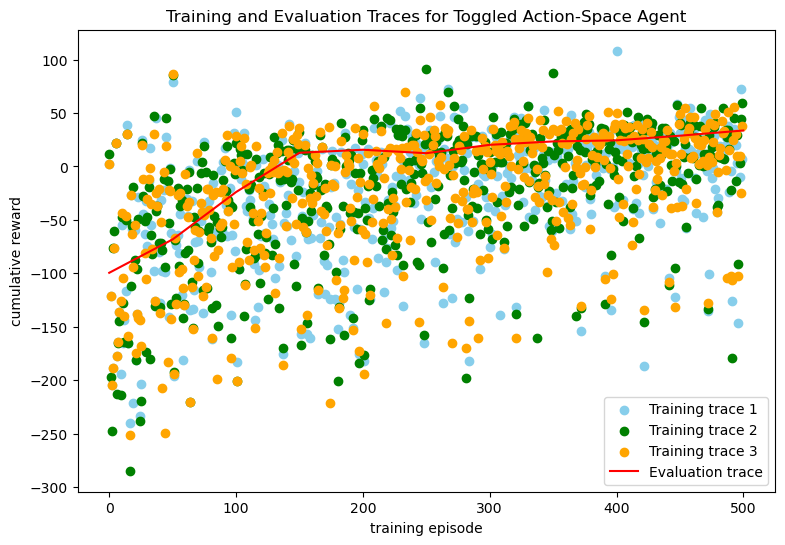

In [100]:
fig, axs = plt.subplots(1, 1, figsize=(9,6))

plot_traces(training_trace_41b_1, training_trace_41b_2, training_trace_41b_3, 
            evaluation_trace_41b_1,
            evaluation_trace_41b_2,
            evaluation_trace_41b_3,
            title="Training and Evaluation Traces for Toggled Action-Space Agent")
plt.savefig('report_figs/41b_train_eval_traces.pdf', format="pdf", bbox_inches="tight")
plt.show()

### Run 3 episodes

In [250]:
## Choose best run:

print(f'last evaluation reward trace 1 = {max(evaluation_trace_41b_1)}')
print(f'last evaluation reward trace 2 = {max(evaluation_trace_41b_2)}')
print(f'last evaluation reward trace 3 = {max(evaluation_trace_41b_3)}')

# # Choose run 2
# last evaluation reward trace 1 = 32.59561207294464
# last evaluation reward trace 2 = 35.32142524719238
# last evaluation reward trace 3 = 34.55965752601624

last evaluation reward trace 1 = 32.59561207294464
last evaluation reward trace 2 = 35.32142524719238
last evaluation reward trace 3 = 34.55965752601624


In [47]:
agent = DQNAgent(env_41, env_41_eval, seed2, n_actions=5, eps_start=0.7, eps_end=0.2, num_episodes=500, num_episodes_eval=20)
agent.load_model(savepath="./models/toggle_2/", device='cpu')


using LR=0.005
network with seed = 53
using device: cpu


running one episode with torch seed = 42 and env seed = 42


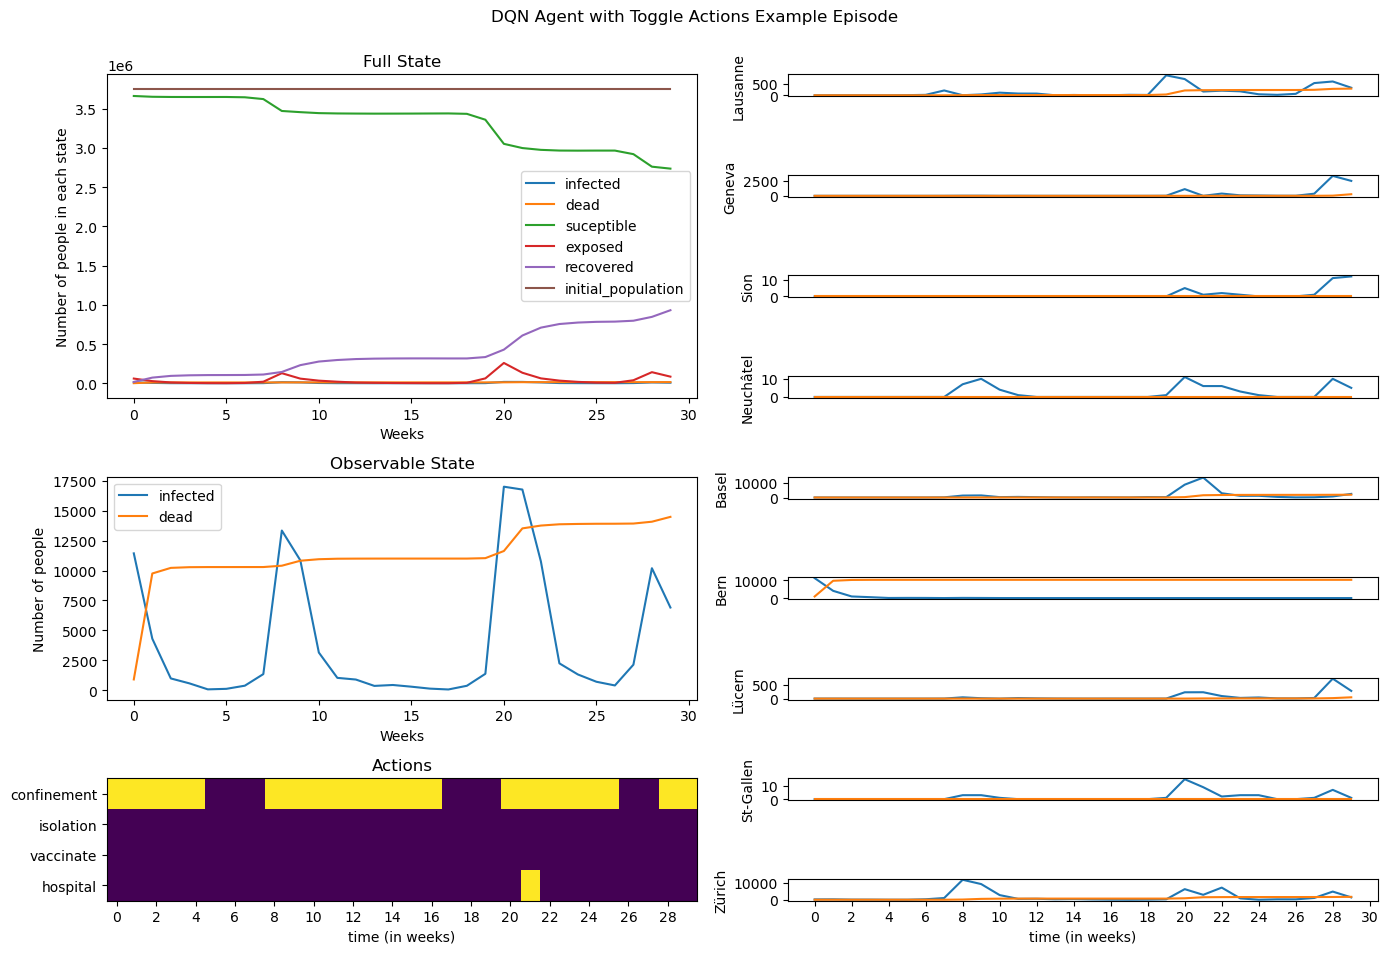

In [25]:
_ = plot_one_episode(agent, env_41_eval, save_path="report_figs/4b_episode_1.pdf", episode_seed=42, title="DQN Agent with Toggle Actions Example Episode")

running one episode with torch seed = 42 and env seed = 43


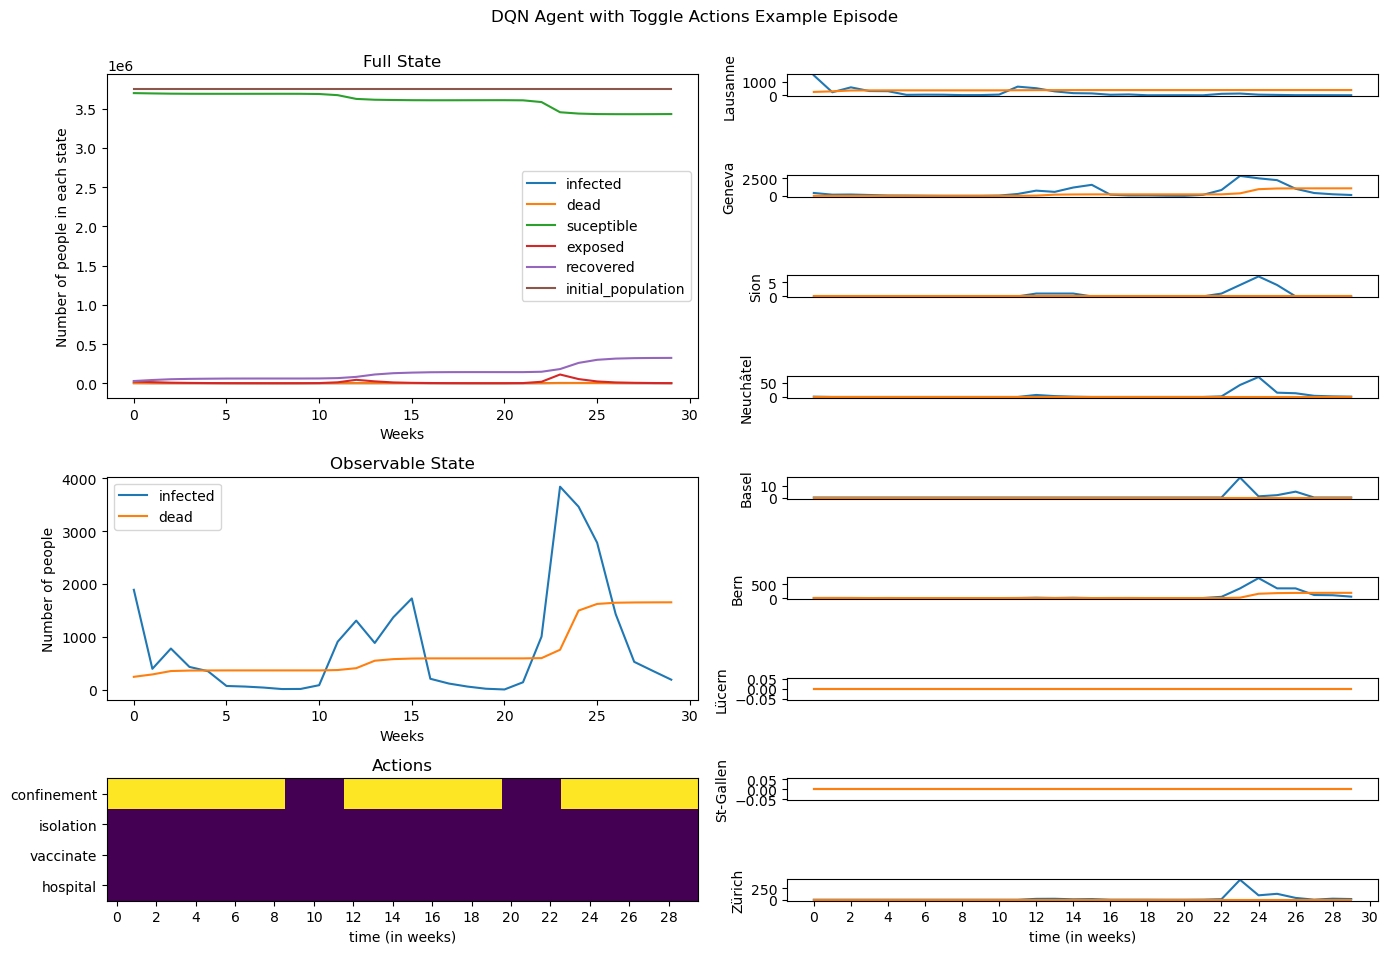

In [28]:
_ = plot_one_episode(agent, env_41_eval, save_path="report_figs/4b_episode_2.pdf", episode_seed=43,  title="DQN Agent with Toggle Actions Example Episode")

running one episode with torch seed = 42 and env seed = 44


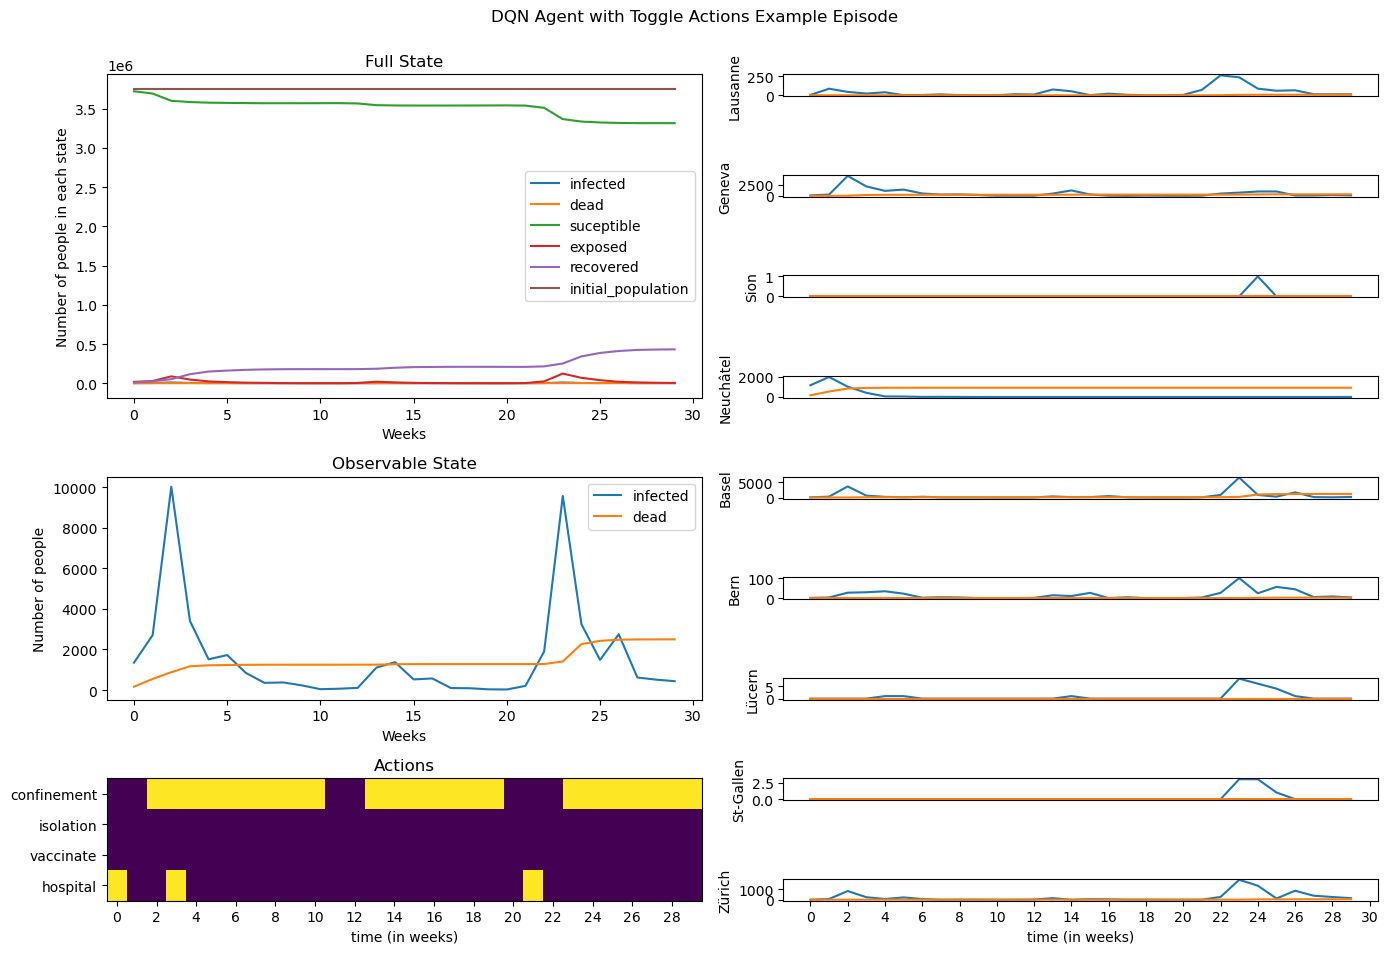

In [48]:
q_values_toggled = plot_one_episode(agent, env_41_eval, save_path="report_figs/4b_episode_3.pdf", episode_seed=44, title="DQN Agent with Toggle Actions Example Episode")

## Question 4.c

evaluating with seed: 42


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


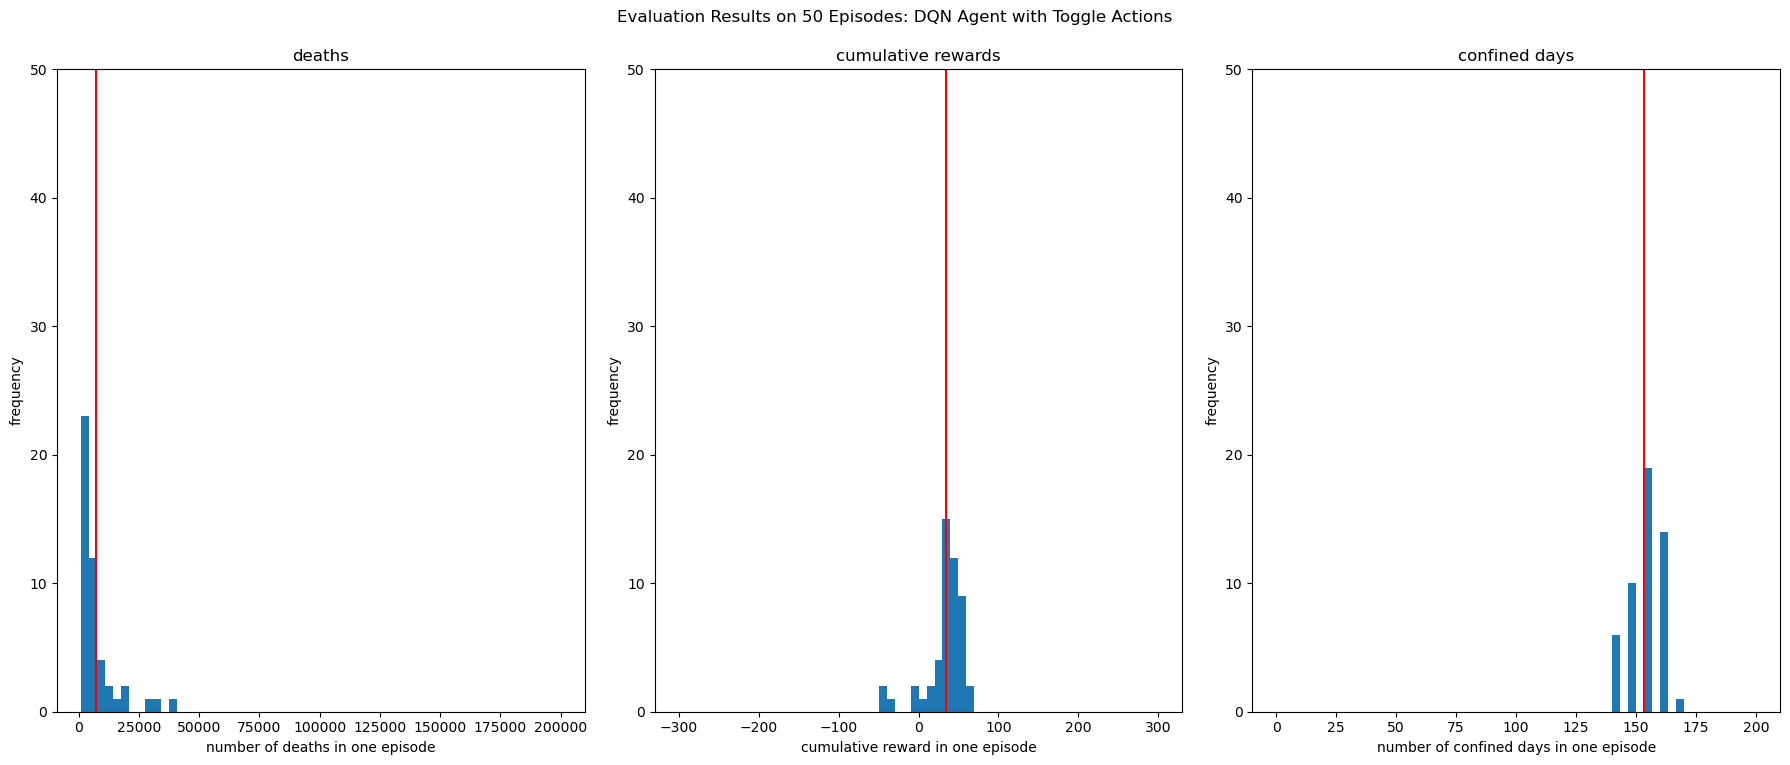

Average death number: 7110.6
Average cumulative reward: 33.93315209388733
Average number of confined days: 153.16


In [49]:
plot_statistics(agent, env_41_eval, "report_figs/41c.pdf", title="DQN Agent with Toggle Actions")

## Question 4.2: Factorized Q-values, multi-action agent

In [ ]:
def action_preprocessor_factorized(a:int, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }

    # print(type(a))
    # a = [int(i) for i in list(f'{a:04b}')]

    a = a.squeeze()
    # print(a)
    # print(a)
    if a[0] == 1:
        action['confinement'] = True
    if a[1] == 1:
        action['isolation'] = True
    if a[2] == 1:
        action['hospital'] = True
    if a[3] == 1:
        action['vaccinate'] = True

    return action

In [186]:
class DQNAgentFactorized(DQNAgent):
    def __init__(self,
                env:Env,
                env_eval:Env,
                # Additionnal parameters to be added here
                seed:int,
                n_actions:int=8,
                eps_start:float=0.7,
                eps_end:float=0.7,
                num_episodes:int=500,
                num_episodes_eval:int=2,
                lr=5e-4
                ):
        """
        DQN Agent with factorized Q-values
        """
        super().__init__(env, env_eval, seed, n_actions, eps_start, eps_end, num_episodes, num_episodes_eval, lr)


    def optimize_model(self, losses=[]):
        # This is where one would define the optimization step of an RL algorithm
        if len(self.memory) < self.BATCH_SIZE:
            return
        transitions = self.memory.sample(self.BATCH_SIZE)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=self.device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        # policy_net_input = state_batch.flatten(start_dim=1).to(device)
        policy_net_input = state_batch.to(self.device)
        policy_net_output = self.policy_net(policy_net_input)
        # state_action_values = policy_net_output.gather(1, action_batch)
        state_action_values = policy_net_output.view((-1, 4, 2)).gather(2, action_batch.unsqueeze(-1)).squeeze().sum(dim=-1, keepdim=True)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.BATCH_SIZE, device=self.device)
        with torch.no_grad():
            # target_net_input = non_final_next_states.flatten(start_dim=1).to(self.device)
            target_net_input = non_final_next_states.to(self.device)
            target_net_output = self.target_net(target_net_input)
            # next_state_values[non_final_mask] = target_net_output.max(1)[0]
            next_state_values[non_final_mask] = target_net_output.view((self.BATCH_SIZE, 4, 2)).max(dim=-1)[0].sum(dim=-1)

        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        # print(state_action_values.shape,  expected_state_action_values.shape)
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()
        return 0

    def act(self, obs, do_explore=True):
        # this takes an observation and returns an action
        sample = torch.rand(1)
        # eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * math.exp(-1. * self.steps_done / self.EPS_DECAY)
        eps_threshold = max(self.EPS_END,  self.EPS_START * (1 - self.steps_done / self.num_episodes))
        # print(eps_threshold)
        if do_explore and sample <= eps_threshold:
            # random_action = torch.from_numpy(self.env.action_space.sample()).to(self.device).view(1, -1)
            random_action = torch.tensor(torch.randint(0, 2, (4,)).cpu().detach().tolist(), device=self.device, dtype=torch.long).view(1, -1)
            # print('random_action:', random_action)
            return random_action, []
        else:
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                # dqn_input = obs.flatten().to(self.device)
                dqn_input = obs.to(self.device)
                dqn_output = self.policy_net(dqn_input)
                # print(dqn_output.view(4, 2))
                selected_action = dqn_output.view(4, 2).argmax(dim=-1).to(self.device).long().view(1, -1)
                out = dqn_output.view(4, 2)
                q_values = []
                for d_0 in [0, 1]:
                  for d_1 in [0, 1]:
                    for d_2 in [0, 1]:
                      for d_3 in [0, 1]:
                        q_value = out[0][d_0] + out[1][d_1] + out[2][d_2] + out[3][d_3]
                        q_values.append(q_value)

                # x = torch.tensor([[binary_tensor_to_decimal(selected_action)]])
                # x = torch.tensor([selected_action], device=self.device).long()
                # print('net action', selected_action)
                return selected_action, q_values

In [187]:
env_42 = Env(  dyn,
            action_space=spaces.MultiBinary(4),
            observation_space=None,
            action_preprocessor=action_preprocessor_factorized,
            observation_preprocessor=observation_preprocessor,
            )

env_42_eval = Env(  dyn,
            action_space=spaces.MultiBinary(4),
            observation_space=None,
            action_preprocessor=action_preprocessor_factorized,
            observation_preprocessor=observation_preprocessor,
            )

In [188]:
agent = DQNAgentFactorized(env_42, env_42_eval, seed=29, n_actions=8, eps_start=0.7, eps_end=0.2, num_episodes=500, num_episodes_eval=20, lr=1e-3)

training_trace_42a_1, evaluation_trace_42a_1, losses_42a_1 = agent.train(save_path="./models/factorized_1/")

np.savetxt('report_figs/42a_training_1.csv', training_trace_42a_1, delimiter=',')
np.savetxt('report_figs/42a_evaluation_1.csv', evaluation_trace_42a_1, delimiter=',')
np.savetxt('report_figs/42a_losses_1.csv', losses_42a_1, delimiter=',')

using LR=0.001
network with seed = 29
using device: cpu


  0%|          | 0/500 [00:00<?, ?it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


eval mean cumulative reward: -157.69671630859375
saved model checkpoint!


 10%|█         | 50/500 [01:15<10:24,  1.39s/it] 

evaluating with seed: 42


100%|██████████| 20/20 [00:17<00:00,  1.15it/s]


eval mean cumulative reward: 4.243333244323731
saved model checkpoint!


 20%|██        | 100/500 [02:33<08:11,  1.23s/it]

evaluating with seed: 42


100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


eval mean cumulative reward: 16.483405017852782
saved model checkpoint!


 30%|███       | 150/500 [03:49<06:56,  1.19s/it]

evaluating with seed: 42


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


eval mean cumulative reward: 10.983048105239869


 40%|████      | 200/500 [05:07<06:54,  1.38s/it]

evaluating with seed: 42


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


eval mean cumulative reward: 6.343201541900635


 50%|█████     | 250/500 [06:33<05:04,  1.22s/it]

evaluating with seed: 42


100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


eval mean cumulative reward: 24.202352142333986
saved model checkpoint!


 60%|██████    | 300/500 [08:00<04:13,  1.27s/it]

evaluating with seed: 42


100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


eval mean cumulative reward: 25.707469868659974
saved model checkpoint!


 70%|███████   | 350/500 [09:16<02:42,  1.08s/it]

evaluating with seed: 42


100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


eval mean cumulative reward: 17.15237600803375


 80%|████████  | 400/500 [10:31<01:45,  1.06s/it]

evaluating with seed: 42


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


eval mean cumulative reward: 31.240045857429504
saved model checkpoint!


 90%|█████████ | 450/500 [11:45<01:04,  1.29s/it]

evaluating with seed: 42


100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


eval mean cumulative reward: 21.33276047706604


100%|█████████▉| 499/500 [12:58<00:01,  1.21s/it]

evaluating with seed: 42


100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


eval mean cumulative reward: 28.87008399963379


100%|██████████| 500/500 [13:14<00:00,  1.59s/it]


In [189]:
agent = DQNAgentFactorized(env_42, env_42_eval, seed=45, n_actions=8, eps_start=0.7, eps_end=0.2, num_episodes=500, num_episodes_eval=20, lr=1e-3)
training_trace_42a_2, evaluation_trace_42a_2, losses_42a_2 = agent.train(save_path="./models/factorized_2/")

np.savetxt('report_figs/42a_training_2.csv', training_trace_42a_2, delimiter=',')
np.savetxt('report_figs/42a_evaluation_2.csv', evaluation_trace_42a_2, delimiter=',')
np.savetxt('report_figs/42a_losses_2.csv', losses_42a_2, delimiter=',')

using LR=0.001
network with seed = 45
using device: cpu


  0%|          | 0/500 [00:00<?, ?it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


eval mean cumulative reward: -22.032286643981934
saved model checkpoint!


 10%|█         | 50/500 [01:07<08:40,  1.16s/it] 

evaluating with seed: 42


100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


eval mean cumulative reward: 5.152467423677445
saved model checkpoint!


 20%|██        | 100/500 [02:17<07:35,  1.14s/it]

evaluating with seed: 42


100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


eval mean cumulative reward: 11.231539028882981
saved model checkpoint!


 30%|███       | 150/500 [03:25<06:45,  1.16s/it]

evaluating with seed: 42


100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


eval mean cumulative reward: 17.766584348678588
saved model checkpoint!


 40%|████      | 200/500 [04:34<06:17,  1.26s/it]

evaluating with seed: 42


100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


eval mean cumulative reward: 17.98332281112671
saved model checkpoint!


 50%|█████     | 250/500 [05:41<04:31,  1.09s/it]

evaluating with seed: 42


100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


eval mean cumulative reward: 28.47558422088623
saved model checkpoint!


 60%|██████    | 300/500 [06:51<03:42,  1.11s/it]

evaluating with seed: 42


100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


eval mean cumulative reward: 26.717956852912902


 70%|███████   | 350/500 [08:00<02:43,  1.09s/it]

evaluating with seed: 42


100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


eval mean cumulative reward: 27.551418340206148


 80%|████████  | 400/500 [09:09<01:52,  1.12s/it]

evaluating with seed: 42


100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


eval mean cumulative reward: 29.699679231643678
saved model checkpoint!


 90%|█████████ | 450/500 [10:17<00:55,  1.11s/it]

evaluating with seed: 42


100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


eval mean cumulative reward: 31.93096570968628
saved model checkpoint!


100%|█████████▉| 499/500 [11:24<00:00,  1.00it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


eval mean cumulative reward: 37.65304613113403
saved model checkpoint!


100%|██████████| 500/500 [11:41<00:00,  1.40s/it]


In [190]:
agent = DQNAgentFactorized(env_42, env_42_eval, seed=78, n_actions=8, eps_start=0.7, eps_end=0.2, num_episodes=500, num_episodes_eval=20, lr=1e-3)
training_trace_42a_3, evaluation_trace_42a_3, losses_42a_3 = agent.train(save_path="./models/factorized_3/")

np.savetxt('report_figs/42a_training_3.csv', training_trace_42a_3, delimiter=',')
np.savetxt('report_figs/42a_evaluation_3.csv', evaluation_trace_42a_3, delimiter=',')
np.savetxt('report_figs/42a_losses_3.csv', losses_42a_3, delimiter=',')

using LR=0.001
network with seed = 78
using device: cpu


  0%|          | 0/500 [00:00<?, ?it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


eval mean cumulative reward: -12.42416467666626
saved model checkpoint!


 10%|█         | 50/500 [01:04<07:50,  1.05s/it] 

evaluating with seed: 42


100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


eval mean cumulative reward: 7.5870916724205015
saved model checkpoint!


 20%|██        | 100/500 [02:16<07:32,  1.13s/it]

evaluating with seed: 42


100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


eval mean cumulative reward: 5.310058867931366


 30%|███       | 150/500 [03:14<04:53,  1.19it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


eval mean cumulative reward: 14.616485917568207
saved model checkpoint!


 40%|████      | 200/500 [04:14<04:36,  1.09it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


eval mean cumulative reward: 14.391198790073394


 50%|█████     | 250/500 [05:11<03:50,  1.09it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


eval mean cumulative reward: 18.32608345746994
saved model checkpoint!


 60%|██████    | 300/500 [06:09<03:18,  1.01it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


eval mean cumulative reward: 17.231156611442564


 70%|███████   | 350/500 [07:06<02:11,  1.14it/s]

evaluating with seed: 42


100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


eval mean cumulative reward: 19.43305323123932
saved model checkpoint!


 80%|████████  | 400/500 [08:29<02:17,  1.37s/it]

evaluating with seed: 42


100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


eval mean cumulative reward: 29.012145924568177
saved model checkpoint!


 90%|█████████ | 450/500 [09:58<01:18,  1.57s/it]

evaluating with seed: 42


100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


eval mean cumulative reward: 27.592091286182402


100%|█████████▉| 499/500 [11:21<00:01,  1.26s/it]

evaluating with seed: 42


100%|██████████| 20/20 [00:17<00:00,  1.15it/s]


eval mean cumulative reward: 31.641436672210695
saved model checkpoint!


100%|██████████| 500/500 [11:40<00:00,  1.40s/it]


In [191]:
## Choose best run:

print(f'best evaluation reward trace 1 42a = {max(evaluation_trace_42a_1)}')
print(f'best evaluation reward trace 2 42a = {max(evaluation_trace_42a_2)}')
print(f'best evaluation reward trace 3 42a = {max(evaluation_trace_42a_3)}')

# best agent: agent 2
# best evaluation reward trace 1 42a = 31.240045857429504
# best evaluation reward trace 2 42a = 37.65304613113403
# best evaluation reward trace 3 42a = 31.641436672210695

best evaluation reward trace 1 42a = 31.240045857429504
best evaluation reward trace 2 42a = 37.65304613113403
best evaluation reward trace 3 42a = 31.641436672210695


In [192]:
agent = DQNAgentFactorized(env_42, env_42_eval, seed=45, n_actions=8, eps_start=0.7, eps_end=0.2, num_episodes=500, num_episodes_eval=20, lr=1e-3)
agent.load_model(savepath="./models/factorized_2/", device='cpu')

using LR=0.001
network with seed = 45
using device: cpu


evaluating with seed: 42


100%|██████████| 50/50 [00:39<00:00,  1.28it/s]


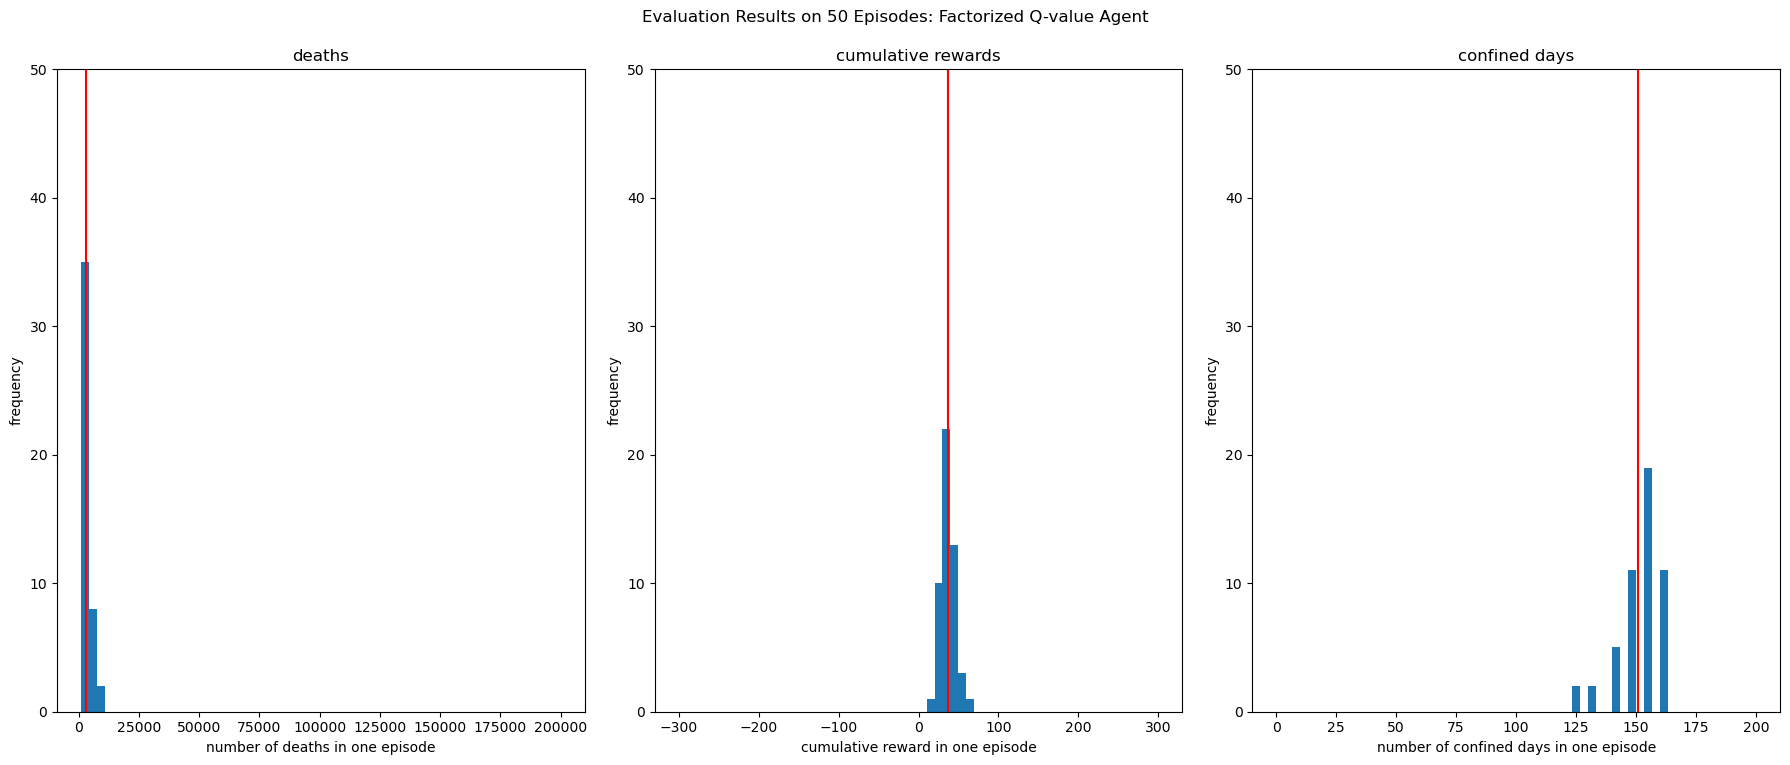

Average death number: 3033.7
Average cumulative reward: 37.38064563751221
Average number of confined days: 150.64


In [193]:
_ = plot_statistics(agent, env_42_eval, "report_figs/42a_evaluation.pdf", title="Factorized Q-value Agent")

In [ ]:
agent = DQNAgentFactorized(env_42, env_42_eval, seed, n_actions=8, eps_start=0.7, eps_end=0.2, num_episodes=500, num_episodes_eval=20)
agent.load_model(savepath="./models/factorized_2/", device='cpu')

using LR=0.5
network with seed = 42
using device: cpu


running one episode with torch seed = 42 and env seed = 42


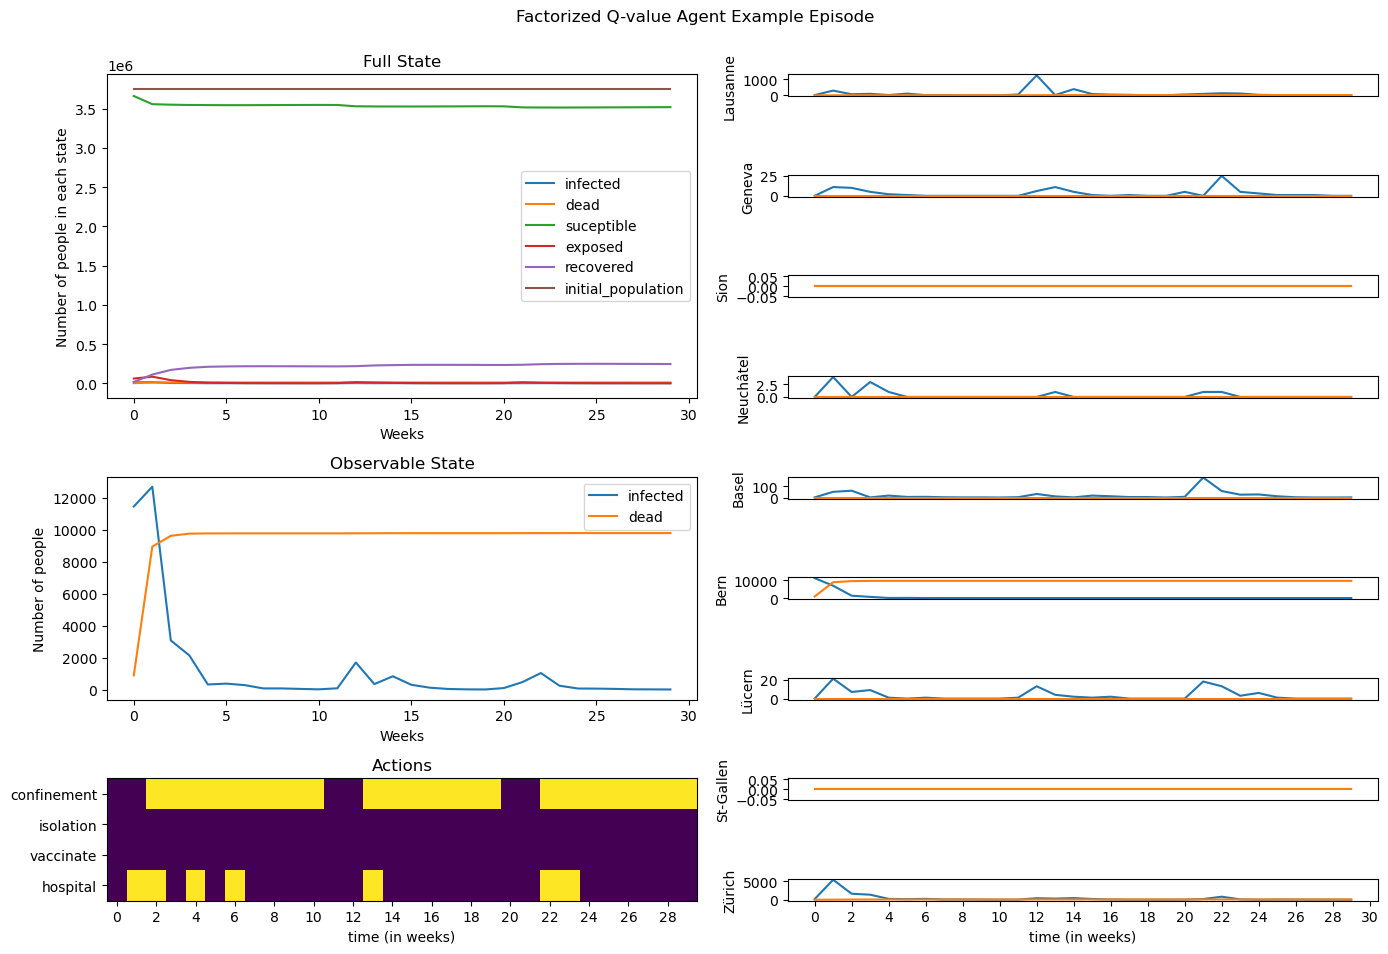

In [203]:
# _ = plot_one_episode(agent, env_42_eval, save_path="report_figs/42a_episode_1.pdf", episode_seed=42, title="Factorized Q-value Agent Example Episode")

running one episode with torch seed = 42 and env seed = 43


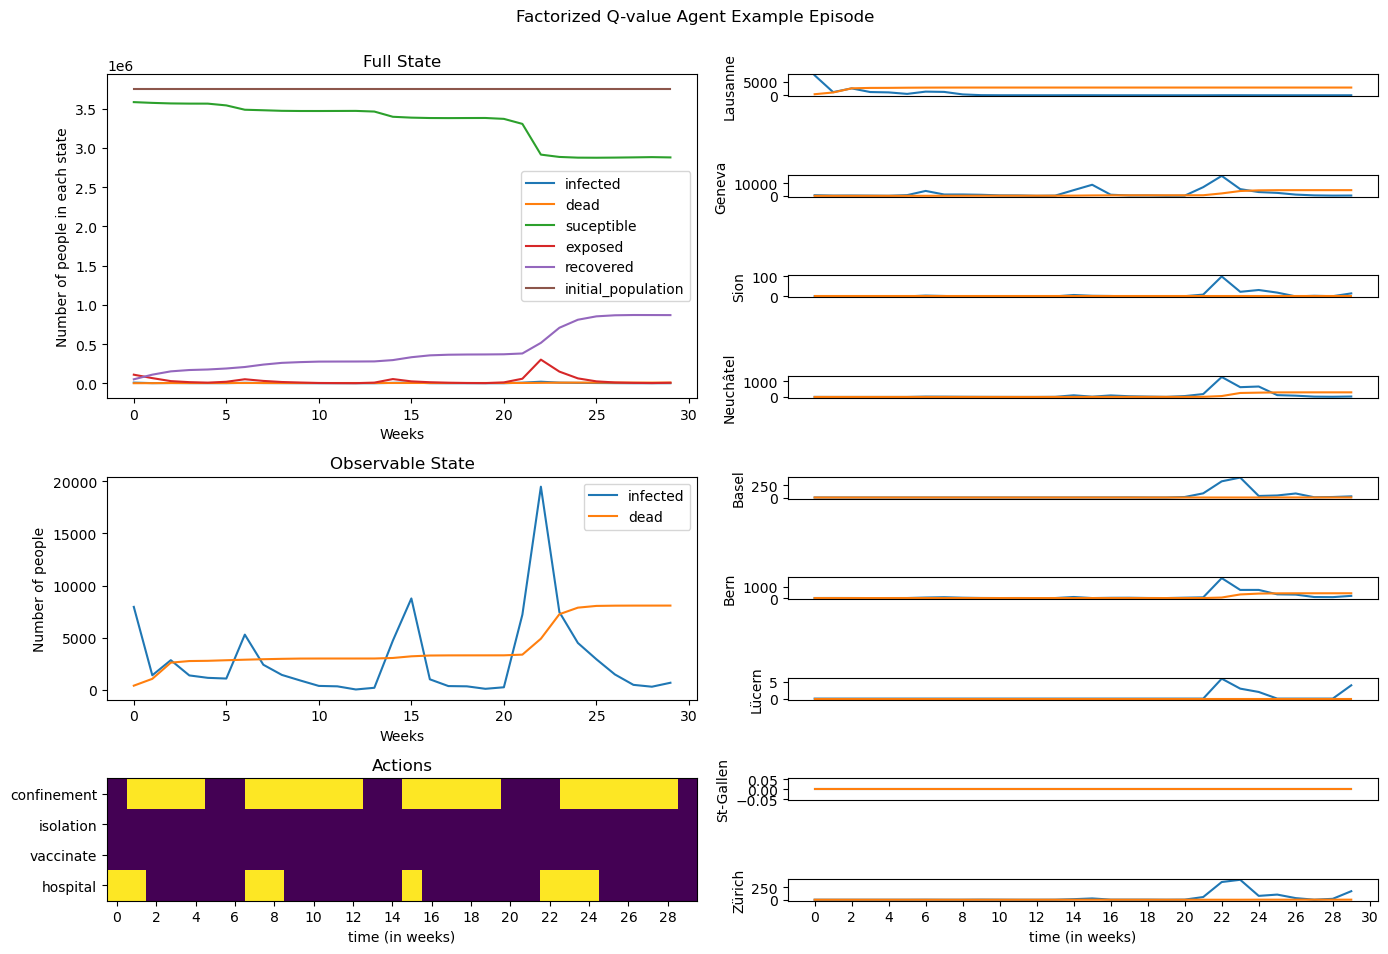

In [204]:
# _ = plot_one_episode(agent, env_42_eval, save_path="report_figs/42a_episode_2.pdf", episode_seed=43, title="Factorized Q-value Agent Example Episode")

running one episode with torch seed = 42 and env seed = 44


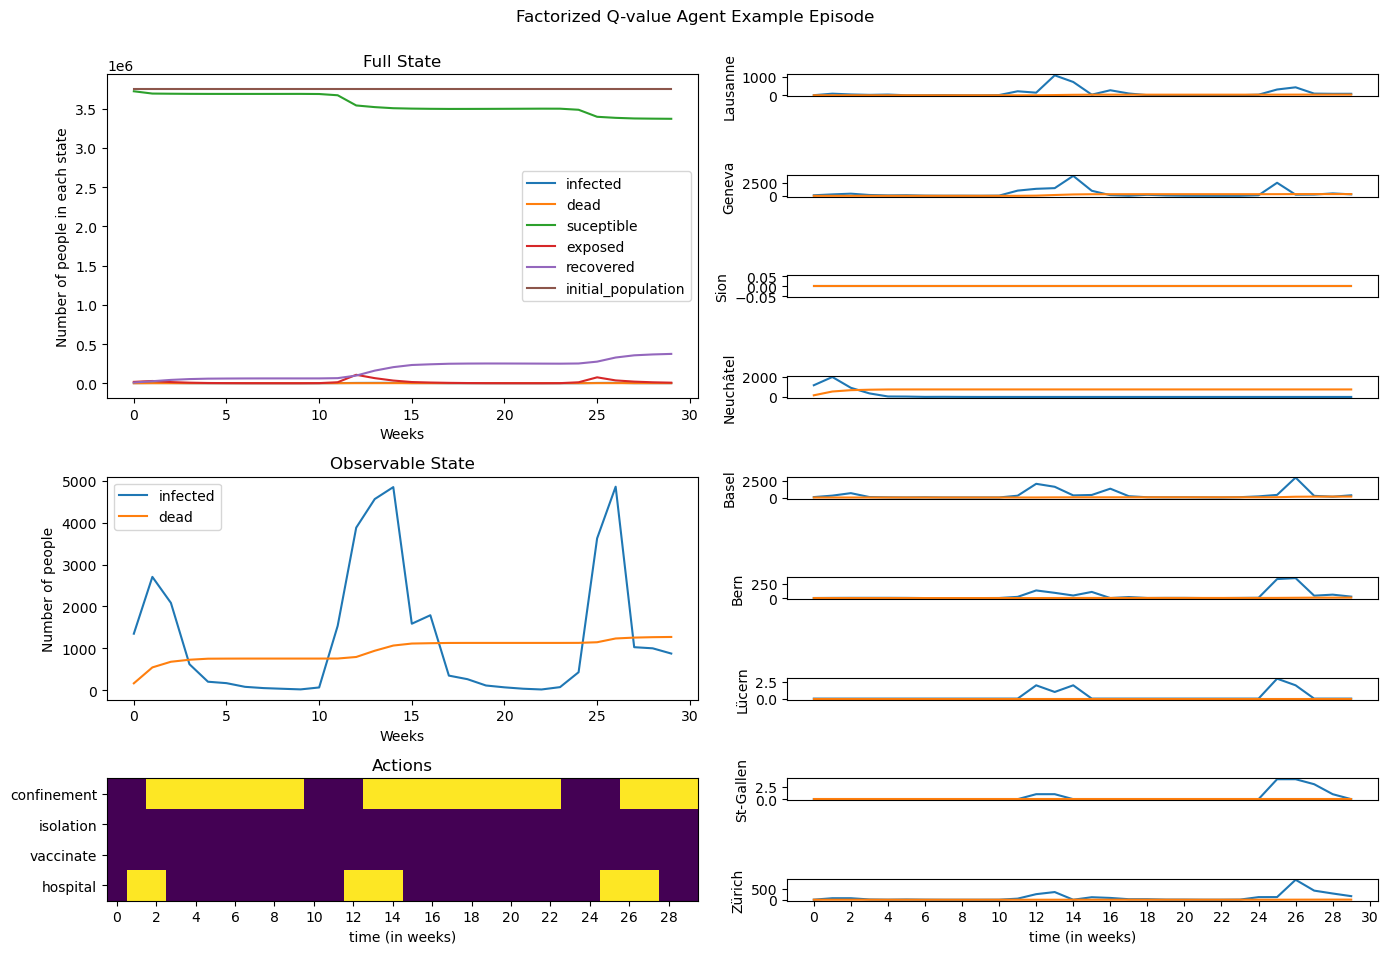

In [206]:
# q_values = plot_one_episode(agent, env_42_eval, save_path="report_figs/42a_episode_2.pdf", episode_seed=44, title="Factorized Q-value Agent Example Episode")

In [101]:
training_trace_42a_1 = np.genfromtxt('report_figs/42a_training_1.csv', delimiter=',', skip_header=0)
training_trace_42a_2 = np.genfromtxt('report_figs/42a_training_2.csv', delimiter=',', skip_header=0)
training_trace_42a_3 = np.genfromtxt('report_figs/42a_training_3.csv', delimiter=',', skip_header=0)

evaluation_trace_42a_1 = np.genfromtxt('report_figs/42a_evaluation_1.csv', delimiter=',', skip_header=0)
evaluation_trace_42a_2 = np.genfromtxt('report_figs/42a_evaluation_2.csv', delimiter=',', skip_header=0)
evaluation_trace_42a_3 = np.genfromtxt('report_figs/42a_evaluation_3.csv', delimiter=',', skip_header=0)


losses_42a_1 = np.genfromtxt('report_figs/42a_losses_1.csv', delimiter=',', skip_header=0)
losses_42a_2 = np.genfromtxt('report_figs/42a_losses_2.csv', delimiter=',', skip_header=0)
losses_42a_3 = np.genfromtxt('report_figs/42a_losses_3.csv', delimiter=',', skip_header=0)

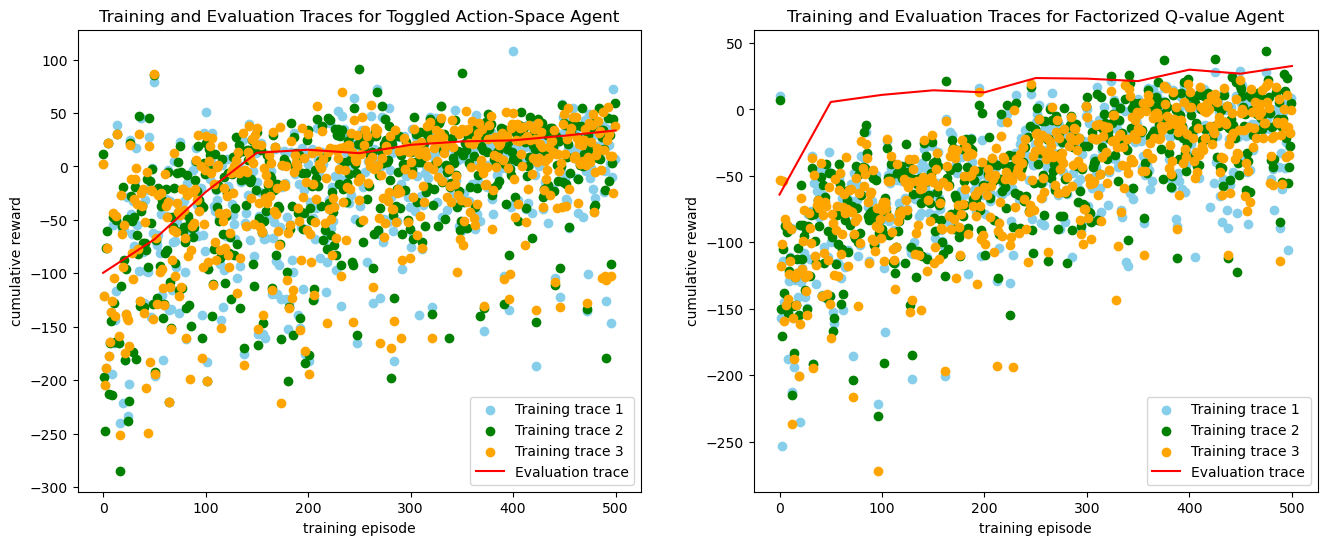

In [102]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))

# choose the first plot
plt.subplot(1, 2, 1)
plot_traces(training_trace_41b_1, training_trace_41b_2, training_trace_41b_3, 
            evaluation_trace_41b_1,
            evaluation_trace_41b_2,
            evaluation_trace_41b_3,
            title="Training and Evaluation Traces for Toggled Action-Space Agent")

plt.subplot(1, 2, 2)
plot_traces(training_trace_42a_1, training_trace_42a_2, training_trace_42a_3, 
            evaluation_trace_42a_1,
            evaluation_trace_42a_2,
            evaluation_trace_42a_3,
            title="Training and Evaluation Traces for Factorized Q-value Agent")
# plot_evaluation_traces(evaluation_trace_3a_1, evaluation_trace_3a_2, evaluation_trace_3a_3, axs[1], title="Evaluation traces with fixed exploration")
plt.savefig('report_figs/42a_train_eval_traces_all.pdf', format="pdf", bbox_inches="tight")
plt.show()

In [51]:
import seaborn as sns
import matplotlib.pylab as plt

In [52]:
def plot_heatmap(q_values, save_path=None, title=None):
    n_weeks = q_values.shape[1]
    if q_values.shape[0] == 2:
        yticks = ['no confinement', 'confinement']
    elif q_values.shape[0] == 5:
        yticks = ['null action', 'toggle confinement', 'toggle isolation', 'toggle hospital', 'toggle vaccination']
    elif q_values.shape[0] == 16:
        yticks = [
            ['no confinement', 'no isolation', 'no hospital', 'no vaccination'],
            ['no confinement', 'no isolation', 'no hospital', 'vaccination'],
            ['no confinement', 'no isolation', 'hospital', 'no vaccination'],
            ['no confinement', 'no isolation', 'hospital', 'vaccination'],
            ['no confinement', 'isolation', 'no hospital', 'no vaccination'],
            ['no confinement', 'isolation', 'no hospital', 'vaccination'],
            ['no confinement', 'isolation', 'hospital', 'no vaccination'],
            ['no confinement', 'isolation', 'hospital', 'vaccination'],
            ['confinement', 'no isolation', 'no hospital', 'no vaccination'],
            ['confinement', 'no isolation', 'no hospital', 'vaccination'],
            ['confinement', 'no isolation', 'hospital', 'no vaccination'],
            ['confinement', 'no isolation', 'hospital', 'vaccination'],
            ['confinement', 'isolation', 'no hospital', 'no vaccination'],
            ['confinement', 'isolation', 'no hospital', 'vaccination'],
            ['confinement', 'isolation', 'hospital', 'no vaccination'],
            ['confinement', 'isolation', 'hospital', 'vaccination'],
    ]
    sns.heatmap(q_values, fmt=".2f", yticklabels= yticks, xticklabels=np.arange(n_weeks))
    plt.title(title)
    plt.xlabel('weeks')
    plt.ylabel('actions')
    if save_path is not None:
        plt.savefig(save_path, format="pdf", bbox_inches="tight")

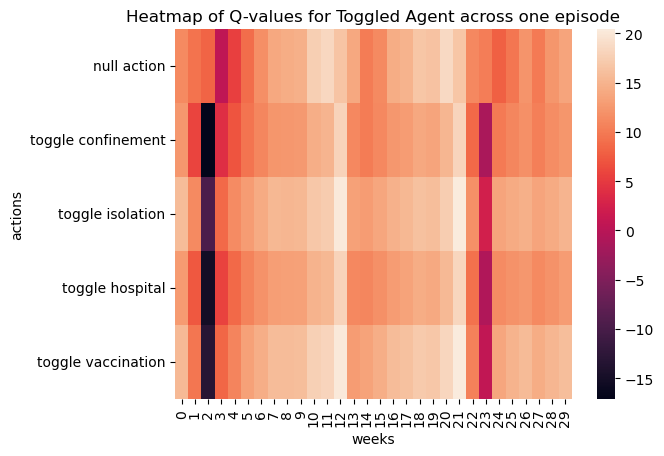

In [54]:
plot_heatmap(q_values_toggled.t(), save_path="report_figs/5c_hitmap_toggled.pdf", title="Heatmap of Q-values for Toggled Agent across one episode")

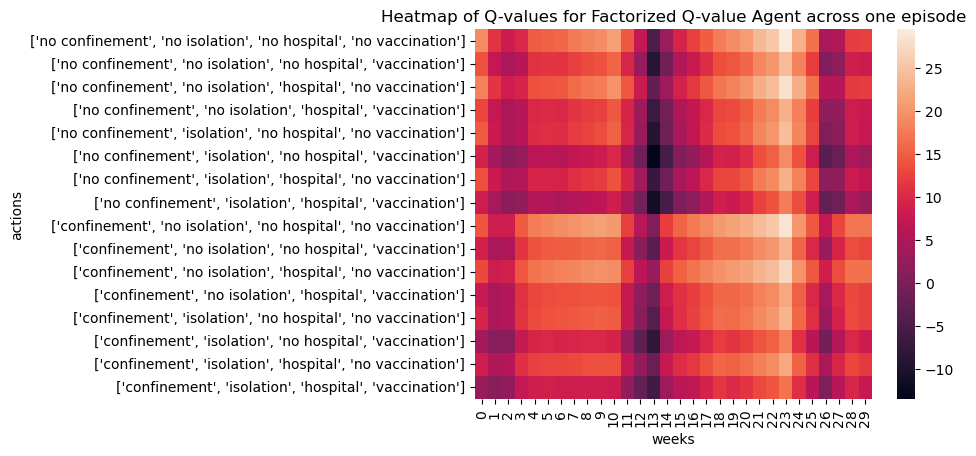

In [249]:
plot_heatmap(q_values.t(), save_path="report_figs/5c_hitmap_factorized.pdf", title="Heatmap of Q-values for Factorized Q-value Agent across one episode")